# Test the performance of the model

## Occurrence of symmetry equivalent structures

### Binary Quadratic Model

In [1]:
from quantum_computing_functions import *
from quantum_computing_postprocessing import *

from dwave.embedding.chain_strength import  uniform_torque_compensation

import numpy as np
import pandas as pd

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor

from ase.visualize import view

In [2]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy
import numpy as np

lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

n_supercell = 2
scaling_matrix = np.identity(3)*n_supercell
scaling_matrix[2][2] = 1
scaling_matrix[1][1] = 1
graphene_supercell = copy.deepcopy(graphene)
graphene_supercell.make_supercell(scaling_matrix)
structure = graphene_supercell
graphene_supercell.num_sites

4

In [896]:
view(AseAtomsAdaptor().get_atoms(graphene_supercell))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

# Loop

In [19]:
#for lagrange in [10,50,100,500,1000]:   
#for num_reads in [100,500,1000,1500,2000,2500]:
from dimod import BinaryQuadraticModel
    
for size in [3]:
    lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

    graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
    graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

    n_supercell = size
    scaling_matrix = np.identity(3)*n_supercell
    scaling_matrix[2][2] = 1
    graphene_supercell = copy.deepcopy(graphene)
    graphene_supercell.make_supercell(scaling_matrix)
    structure = graphene_supercell
    graphene_supercell.num_sites
    
    for vac in [1,2,3,4,5]:
        for ratio in range(1,11):
            structure = graphene_supercell
            use_coord = False
            num_vacancies= vac
            theta = 10
            weight_1 = 1
            weight_2 = 0
            lagrange =  weight_1 * ratio
            num_reads = 1000
            file_path = 'data/discrete/'
            file_name = 'graphene'
            remove_broken_chains = False
            chain_strength = None
            
            Q = build_qubo_discrete(structure,vac,alpha=weight_1,lambda_1=lagrange,theta=theta)
            #print(lagrange,weight_1)
            bqm = BinaryQuadraticModel.from_qubo(Q)

            chain_strength = uniform_torque_compensation(bqm,prefactor=0.3)
        #cqm = build_constrained_quadratic_model(structure,use_coord = use_coord, num_vacancies = num_vacancies, 
                          #weight_1=weight_1, weight_2 = weight_2, lagrange = lagrange)

        #for chain_strength in [uniform_torque_compensation(bqm,prefactor=i) for i in np.arange(0.1,1.1,0.1)]:
            sampleset = run_anneal(bqm,dataframe = False, num_reads=num_reads, 
                                                   return_config_E=False,remove_broken_chains=remove_broken_chains,
                                  chain_strength=chain_strength)

            #dataframe = run_anneal(cqm,num_reads=num_reads, return_config_E=False,remove_broken_chains=remove_broken_chains)

            #save bqm
            save_json_discrete(structure,sampleset,bqm,use_coord=use_coord, num_vacancies=num_vacancies,
                               theta=theta,
              weight_1=weight_1, weight_2=weight_2, lagrange=lagrange, num_reads=num_reads,
              remove_broken_chains = remove_broken_chains,
              file_path=file_path, file_name=file_name, chain_strength=chain_strength)
    

In [4]:
def make_df(directory):

    import os

    #directory = 'data/test/'
    #directory = 'data/chain_strength/utc_0.3/'

    dataframes = []

    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f) and f.endswith(".json") and 'bqm' in f:
            #print(f)
            df, param = load_json(f,return_param = True, return_qubo = False)        
            param = param.transpose()
            n_vac = param['num_vacancies'].values[0]
            n_atoms = param['N atoms'].values[0]
            param['broken_chains'] = find_ratio_broken_chains(df)   
            param['ratio_acceptable'] = find_ratio_acceptable(df)
            param['ratio_feasible'] = find_ratio_feasible_discrete(df,param['num_vacancies'].values[0], remove_broken_chains=False)
            #param['energy_distribution_all'] = ', '.join(str(x) for x in find_energy_distribution(df)[0])
            #param['multiplicity_all'] = ', '.join(str(x) for x in find_energy_distribution(df)[1])        
            param['energy_distribution'] = ', '.join(str(x) for x in find_energy_distribution_discrete(df, only_feasible=True, vacancies=param['num_vacancies'].values[0])[0])
            #param['num_broken_bonds'] = ', '.join(str(x) for x in find_num_broken_bonds(dataframe, remove_broken_chains = True, only_feasible = True, vacancies = param['num_vacancies'].values[0]))
            param['multiplicity'] = ', '.join(str(x) for x in find_energy_distribution_discrete(df, only_feasible=True, vacancies=param['num_vacancies'].values[0])[1])
            param['ratio l/w'] =  param['lagrange'] / param['weight_1'] 
            param['ratio t/w'] = param['theta'] / param['weight_1'] 
            param['vacancies'] = ', '.join(str(x) for x in find_vacancy_distribution(df)[0])
            param['vacancies mult'] = ', '.join(str(x) for x in find_vacancy_distribution(df)[1])


            #print(energy_distribution(df, only_feasible=True, vacancies=n_vac))
            '''if energy_distribution(df, only_feasible=True, vacancies=n_vac)[0][0] == -(-1 - n_vac*2+n_atoms*1.5):
                param['min_found'] = True
            else:
                param['min_found'] = False'''
            if 'chain_strength' not in param:
                param['chain_strength'] = -1
            #print(param['chain_strength'])
            if param['chain_strength'].all() == None:
                param['chain_strength'] = -1
            dataframes.append(param)

    df_results = pd.concat(dataframes)
    
    return df_results

## $\lambda$ , $\alpha$ ratio

### weight_1 = 1

In [10]:
df_results = make_df('./data/discrete/')
df_results

,date_time,time_stamp,structure,N atoms,model,use_coord,num_vacancies,theta,weight_1,weight_2,...,qpu_anneal_time_per_sample,broken_chains,ratio_acceptable,ratio_feasible,energy_distribution,multiplicity,ratio l/w,ratio t/w,vacancies,vacancies mult
Values,"08/17/2022, 14:44:54",1660747494,C18,18,bqm,False,2,7,1,0,...,20.0,0.686,0.627,0.410,"-642.0, -640.0","134, 276",2.0,7.0,"25, 26, 27, 28, 29","3, 48, 813, 132, 4"
Values,"08/17/2022, 14:45:00",1660747500,C18,18,bqm,False,2,9,1,0,...,20.0,0.403,0.654,0.438,"-678.0, -676.0","154, 284",2.0,9.0,"26, 27, 28, 29","34, 843, 116, 7"
Values,"08/17/2022, 14:46:30",1660747590,C18,18,bqm,False,3,15,1,0,...,20.0,0.145,0.866,0.499,"-733.0, -731.0, -729.0","92, 227, 180",2.0,15.0,"26, 27, 28","18, 935, 47"
Values,"08/17/2022, 14:45:38",1660747538,C18,18,bqm,False,3,1,1,0,...,20.0,1.000,0.008,0.002,"-481.0, -477.0","1, 1",2.0,1.0,"24, 25, 26, 27, 28, 29, 30","7, 62, 204, 407, 261, 52, 7"
Values,"08/17/2022, 14:46:20",1660747580,C18,18,bqm,False,3,13,1,0,...,20.0,0.161,0.791,0.498,"-697.0, -695.0, -693.0","77, 230, 191",2.0,13.0,"25, 26, 27, 28, 29","1, 29, 869, 99, 2"
Values,"08/17/2022, 14:39:17",1660747157,C18,18,bqm,False,3,100,1,0,...,20.0,0.051,0.917,0.027,"-2263.0, -2261.0, -2259.0","4, 9, 14",2.0,100.0,"26, 27, 28","11, 966, 23"
Values,"08/17/2022, 14:44:03",1660747443,C18,18,bqm,False,1,11,1,0,...,20.0,0.493,0.708,0.469,-775.0,469,2.0,11.0,"26, 27, 28, 29","80, 832, 86, 2"
Values,"08/17/2022, 14:43:56",1660747436,C18,18,bqm,False,1,9,1,0,...,20.0,0.496,0.652,0.443,-739.0,443,2.0,9.0,"25, 26, 27, 28, 29","1, 41, 897, 60, 1"
Values,"08/17/2022, 14:37:41",1660747061,C18,18,bqm,False,1,10,1,0,...,20.0,0.562,0.755,0.538,-757.0,538,2.0,10.0,"26, 27, 28, 29","62, 859, 78, 1"
Values,"08/17/2022, 14:38:23",1660747103,C18,18,bqm,False,2,10,1,0,...,20.0,0.347,0.789,0.536,"-696.0, -694.0","148, 388",2.0,10.0,"25, 26, 27, 28","1, 37, 894, 68"


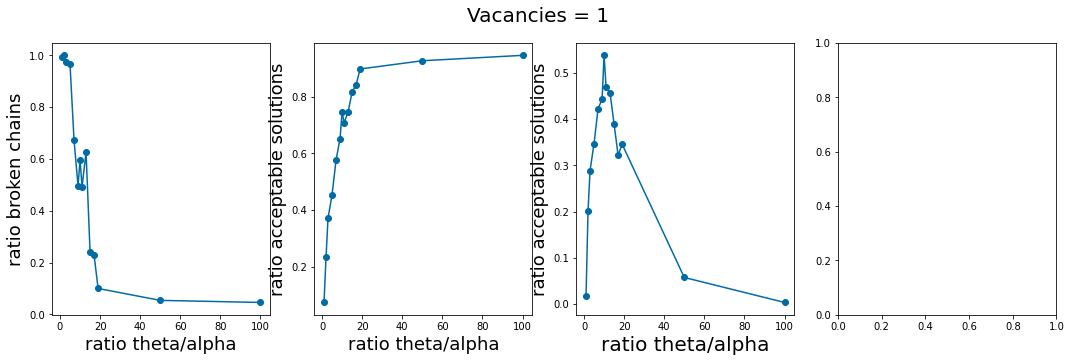

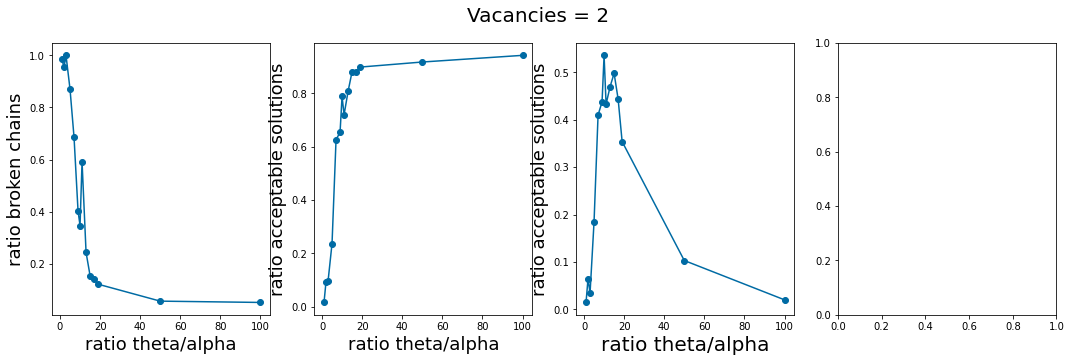

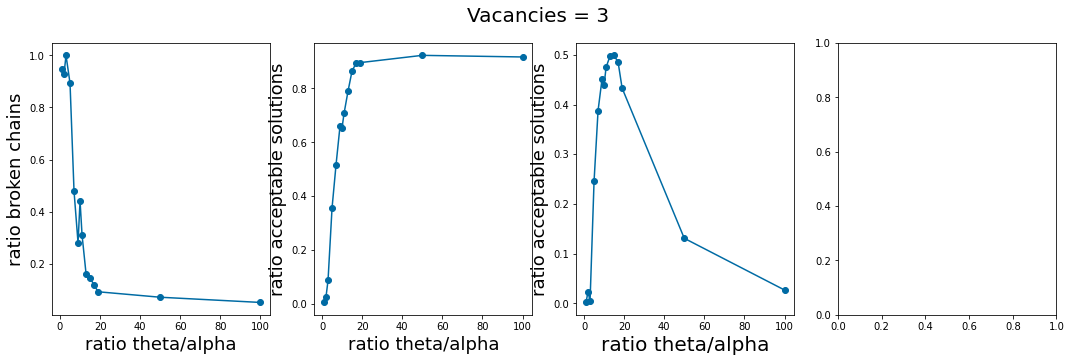

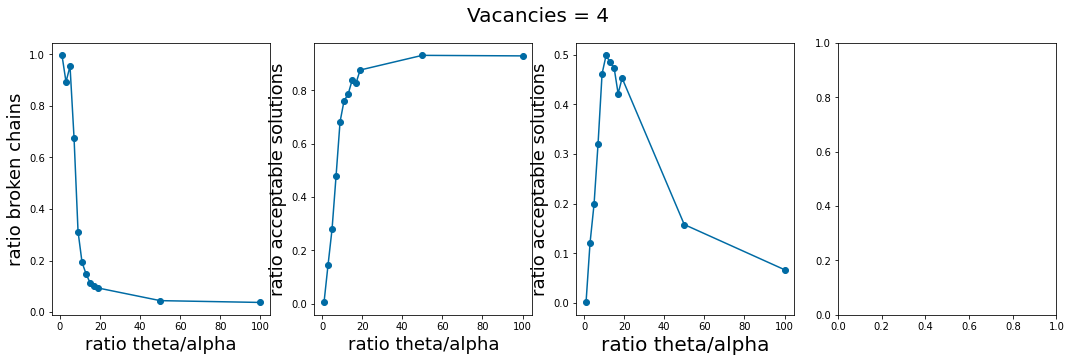

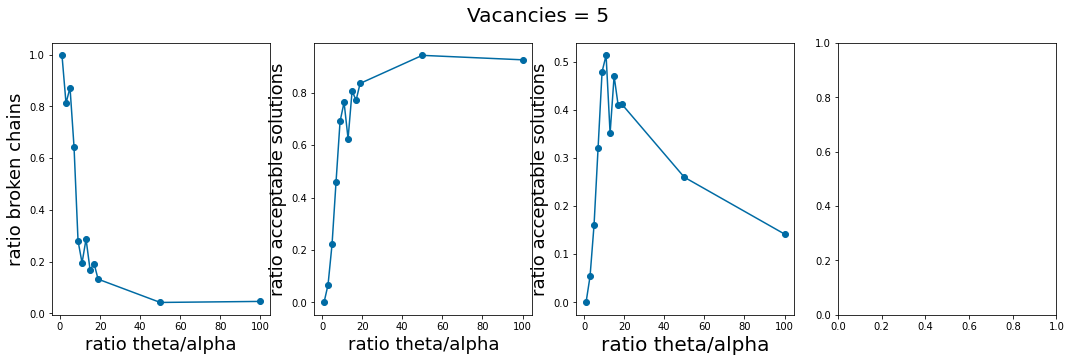

In [17]:
import matplotlib.pyplot as plt
np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

df_results = make_df('./data/discrete/')

for vac in [1,2,3,4,5]:    
    df_all = df_results[df_results['num_vacancies'] == vac]
    df_all = df_all[df_all['lagrange'] == 2.]
    df_mean = df_all[df_all['weight_1'] == 1.].groupby('ratio t/w').mean()
    fig, axs = plt.subplots(1,4,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    x = df_mean.index.values

    y1 = df_mean['broken_chains'].to_numpy()
    y2 = df_mean['ratio_acceptable'].to_numpy()
    y3 = df_mean['ratio_feasible'].to_numpy()

    '''y3 = []
    y4 = []
    error_y3 = []
    error_y4 = []
    error_bc = []
    error_rf = []
    for n,k in enumerate(x):
        
        df_tmp = df_all[df_all['ratio t/w'] == k]
        
        energies = []
        for i in df_all['energy_distribution']:
            energies.extend([float(x) for x in i.split(',')])         
        all_energies = np.unique(np.array(energies))
        labels = [str(x) for x in range(len(all_energies))]
        dist_average = np.array([0]*len(all_energies))
        all_dist = []
        
        vacancies = []
        for i in df_all['vacancies']:
            vacancies.extend([float(x) for x in i.split(',')])         
        all_vacancies = np.unique(np.array(vacancies))
        labels_vac = [str(x) for x in range(len(all_vacancies))]
        dist_vac_average = np.array([0]*len(all_vacancies))
        all_vac = []
        
        error_bc.append(np.std(df_tmp['broken_chains'].to_numpy()))
        error_rf.append(np.std(df_tmp['ratio_feasible'].to_numpy()))
        for j in range(len(df_tmp['energy_distribution'].to_list())):
            distribution = []
            error = []
            v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
            v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
            for i in all_energies:
                v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
                v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
                pos = np.where(np.round(v_energy,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    distribution.append(int(v_mult[pos[0]]))
                else:
                    distribution.append(0)
            all_dist.append(distribution) 
        y3.append(np.average(np.array(all_dist),axis=0).astype(int).tolist())
        
        error_y3.append(np.std(all_dist,axis=0))
        for j in range(len(df_tmp['vacancies'].to_list())):
            vacancies = []
            error = []
            v_vacancies = np.array([float(x) for x in df_tmp['vacancies'].to_list()[j].split(',')])
            v_vac_mult = np.array([float(x) for x in df_tmp['vacancies mult'].to_list()[j].split(',')])
            
            for i in all_vacancies:
                pos = np.where(np.round(v_vacancies,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    vacancies.append(int(v_vac_mult[pos[0]]))
                else:
                    vacancies.append(0)
            all_vac.append(vacancies) 
        y4.append(np.average(np.array(all_vac),axis=0).astype(int).tolist())
        error_y4.append(np.std(all_vac,axis=0))
    y3 = np.array(y3)
    error_y3 = np.array(error_y3)
    y4 = np.array(y4)

    # Normalise wrt the vacancy ( y =1 for vacancy = 1 for all values of x)
    y4 = y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])

    # Normalise wrt the multiplicity of states
    #y4 = y4/partition_f[:y4.shape[1]]
    
    error_y4 = np.array(error_y4)
    error_y4 = error_y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])
    ##error_y4 = error_y4/np.array(np.array([error_y4[:,vac]]*error_y4.shape[1]).transpose())
    #error_y4 = error_y4/partition_f[:y4.shape[1]]
    
    for m in range(len(y3[0])):
        axs[2].errorbar(x,y3[:,m],yerr=error_y3[:,m]/2,fmt='-o',label=labels[m],capsize=5)
    
    for m in range(len(y4[0])):
        #axs[3].errorbar(x,y4[:,m],yerr=error_y4[:,m]/2,fmt='-o',color=color[m],label=int(all_vacancies[m]),capsize=5)
        axs[3].plot(x,y4[:,m],'-o',label=int(all_vacancies[m]))

    axs[2].legend()
    axs[3].legend()'''


    '''axs[0].errorbar(x, y1, yerr = np.array(error_bc)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, y2,yerr = np.array(error_rf)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, y3,yerr = np.array(error_rf)/2,fmt='-o',capsize=5)'''
    axs[0].plot(x, y1,'-o')
    axs[1].plot(x, y2,'-o')
    axs[2].plot(x, y3,'-o')
    axs[0].set_xlabel('ratio theta/alpha', fontsize=18)
    axs[1].set_xlabel('ratio theta/alpha', fontsize=18)
    axs[2].set_xlabel('ratio theta/alpha', fontsize=20)
    axs[0].set_ylabel('ratio broken chains', fontsize=18)
    axs[1].set_ylabel('ratio acceptable solutions', fontsize=18)
    axs[2].set_ylabel('ratio acceptable solutions', fontsize=18)

       
    #fig.set_title('All feasible',fontsize=20)

#axs[:].set_xticks(np.arange(0,25))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

#fig.set_size_inches(15.5, 7.5)

plt.show()

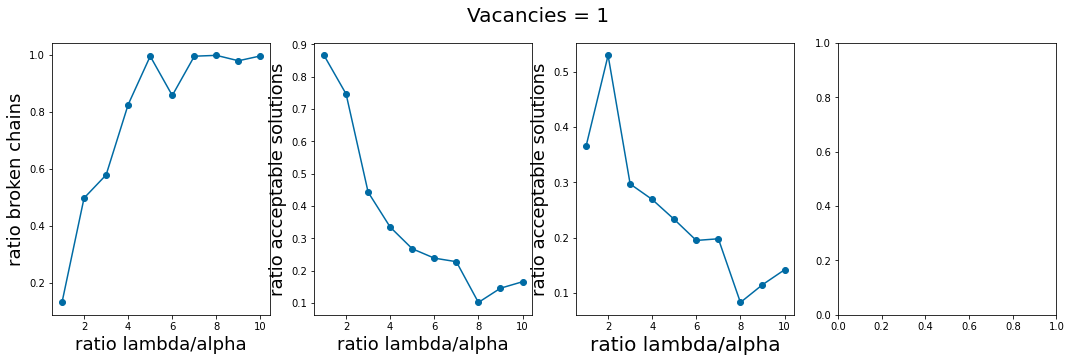

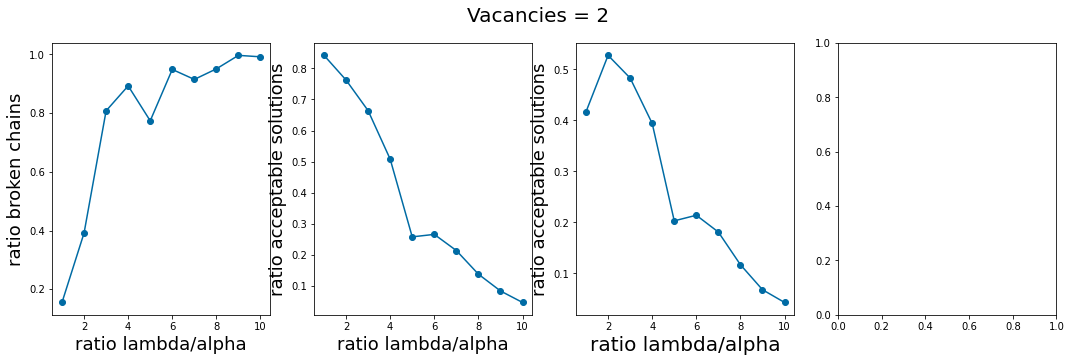

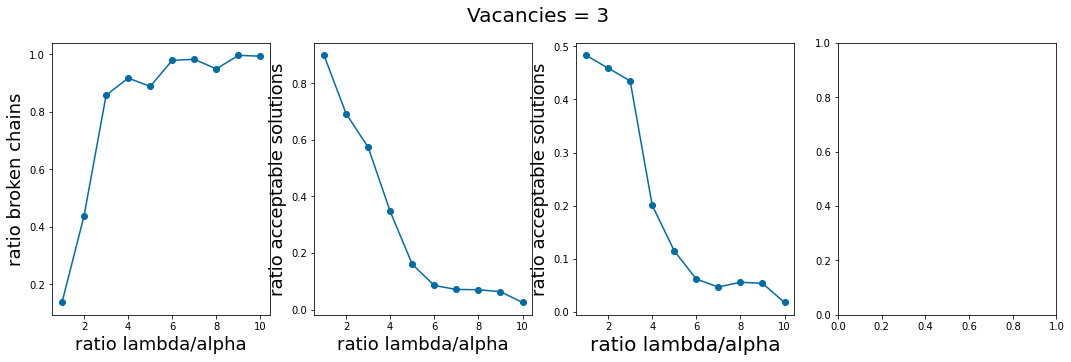

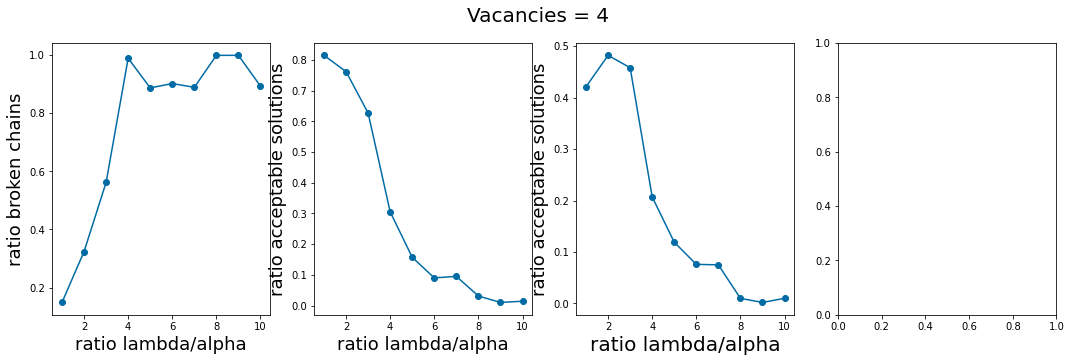

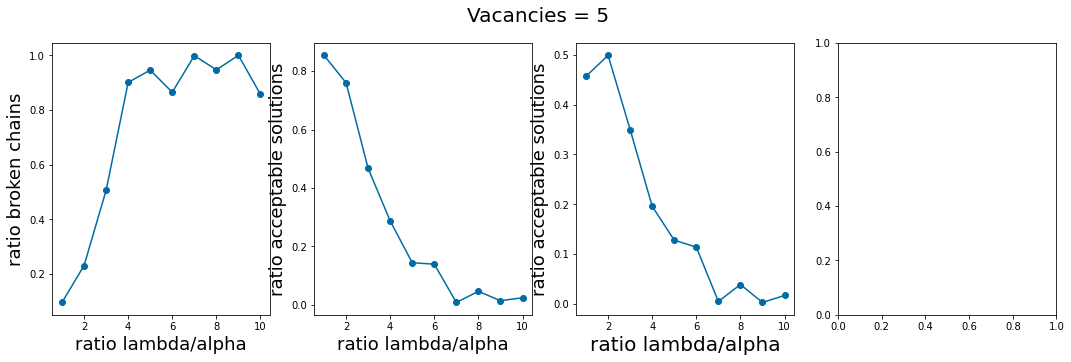

In [20]:
import matplotlib.pyplot as plt
np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

df_results = make_df('./data/discrete/')

for vac in [1,2,3,4,5]:    
    df_all = df_results[df_results['num_vacancies'] == vac]
    df_all = df_all[df_all['theta'] == 10]
    df_mean = df_all[df_all['weight_1'] == 1.].groupby('ratio l/w').mean()
    fig, axs = plt.subplots(1,4,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    x = df_mean.index.values

    y1 = df_mean['broken_chains'].to_numpy()
    y2 = df_mean['ratio_acceptable'].to_numpy()
    y3 = df_mean['ratio_feasible'].to_numpy()

    '''y3 = []
    y4 = []
    error_y3 = []
    error_y4 = []
    error_bc = []
    error_rf = []
    for n,k in enumerate(x):
        
        df_tmp = df_all[df_all['ratio t/w'] == k]
        
        energies = []
        for i in df_all['energy_distribution']:
            energies.extend([float(x) for x in i.split(',')])         
        all_energies = np.unique(np.array(energies))
        labels = [str(x) for x in range(len(all_energies))]
        dist_average = np.array([0]*len(all_energies))
        all_dist = []
        
        vacancies = []
        for i in df_all['vacancies']:
            vacancies.extend([float(x) for x in i.split(',')])         
        all_vacancies = np.unique(np.array(vacancies))
        labels_vac = [str(x) for x in range(len(all_vacancies))]
        dist_vac_average = np.array([0]*len(all_vacancies))
        all_vac = []
        
        error_bc.append(np.std(df_tmp['broken_chains'].to_numpy()))
        error_rf.append(np.std(df_tmp['ratio_feasible'].to_numpy()))
        for j in range(len(df_tmp['energy_distribution'].to_list())):
            distribution = []
            error = []
            v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
            v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
            for i in all_energies:
                v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
                v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
                pos = np.where(np.round(v_energy,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    distribution.append(int(v_mult[pos[0]]))
                else:
                    distribution.append(0)
            all_dist.append(distribution) 
        y3.append(np.average(np.array(all_dist),axis=0).astype(int).tolist())
        
        error_y3.append(np.std(all_dist,axis=0))
        for j in range(len(df_tmp['vacancies'].to_list())):
            vacancies = []
            error = []
            v_vacancies = np.array([float(x) for x in df_tmp['vacancies'].to_list()[j].split(',')])
            v_vac_mult = np.array([float(x) for x in df_tmp['vacancies mult'].to_list()[j].split(',')])
            
            for i in all_vacancies:
                pos = np.where(np.round(v_vacancies,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    vacancies.append(int(v_vac_mult[pos[0]]))
                else:
                    vacancies.append(0)
            all_vac.append(vacancies) 
        y4.append(np.average(np.array(all_vac),axis=0).astype(int).tolist())
        error_y4.append(np.std(all_vac,axis=0))
    y3 = np.array(y3)
    error_y3 = np.array(error_y3)
    y4 = np.array(y4)

    # Normalise wrt the vacancy ( y =1 for vacancy = 1 for all values of x)
    y4 = y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])

    # Normalise wrt the multiplicity of states
    #y4 = y4/partition_f[:y4.shape[1]]
    
    error_y4 = np.array(error_y4)
    error_y4 = error_y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])
    ##error_y4 = error_y4/np.array(np.array([error_y4[:,vac]]*error_y4.shape[1]).transpose())
    #error_y4 = error_y4/partition_f[:y4.shape[1]]
    
    for m in range(len(y3[0])):
        axs[2].errorbar(x,y3[:,m],yerr=error_y3[:,m]/2,fmt='-o',label=labels[m],capsize=5)
    
    for m in range(len(y4[0])):
        #axs[3].errorbar(x,y4[:,m],yerr=error_y4[:,m]/2,fmt='-o',color=color[m],label=int(all_vacancies[m]),capsize=5)
        axs[3].plot(x,y4[:,m],'-o',label=int(all_vacancies[m]))

    axs[2].legend()
    axs[3].legend()'''


    '''axs[0].errorbar(x, y1, yerr = np.array(error_bc)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, y2,yerr = np.array(error_rf)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, y3,yerr = np.array(error_rf)/2,fmt='-o',capsize=5)'''
    axs[0].plot(x, y1,'-o')
    axs[1].plot(x, y2,'-o')
    axs[2].plot(x, y3,'-o')
    axs[0].set_xlabel('ratio lambda/alpha', fontsize=18)
    axs[1].set_xlabel('ratio lambda/alpha', fontsize=18)
    axs[2].set_xlabel('ratio lambda/alpha', fontsize=20)
    axs[0].set_ylabel('ratio broken chains', fontsize=18)
    axs[1].set_ylabel('ratio acceptable solutions', fontsize=18)
    axs[2].set_ylabel('ratio acceptable solutions', fontsize=18)

       
    #fig.set_title('All feasible',fontsize=20)

#axs[:].set_xticks(np.arange(0,25))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

#fig.set_size_inches(15.5, 7.5)

plt.show()

### weight_1 = 1

### utc prefactor = 0.3

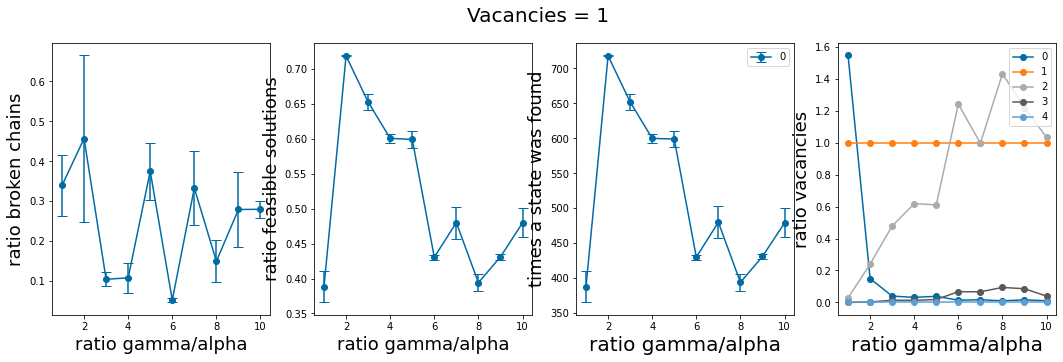

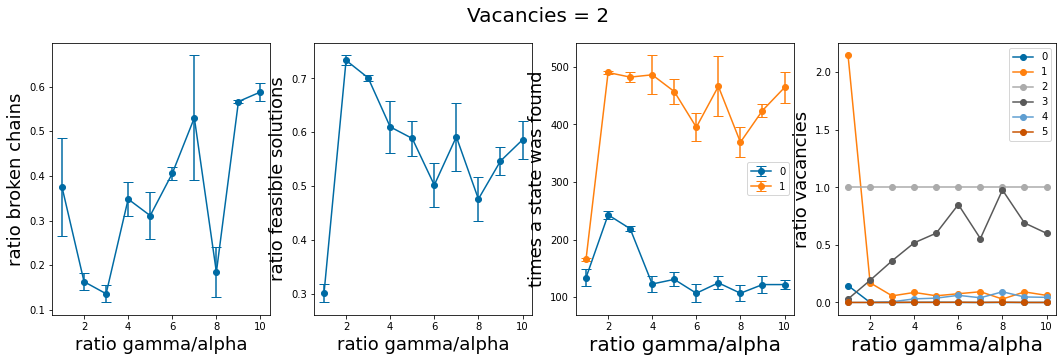

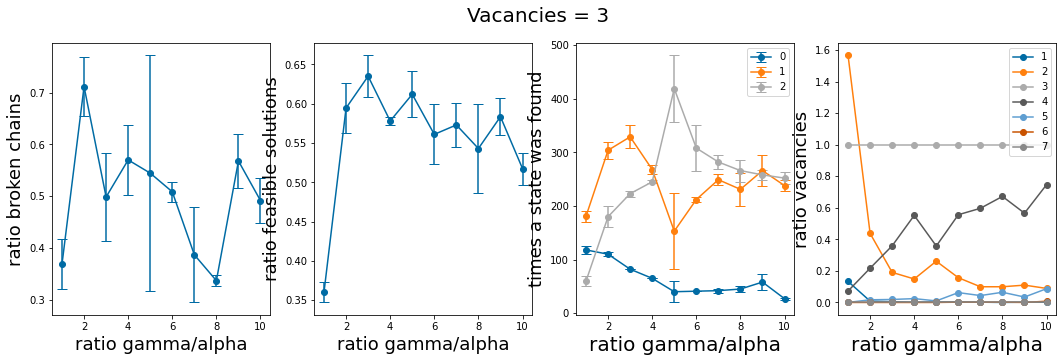

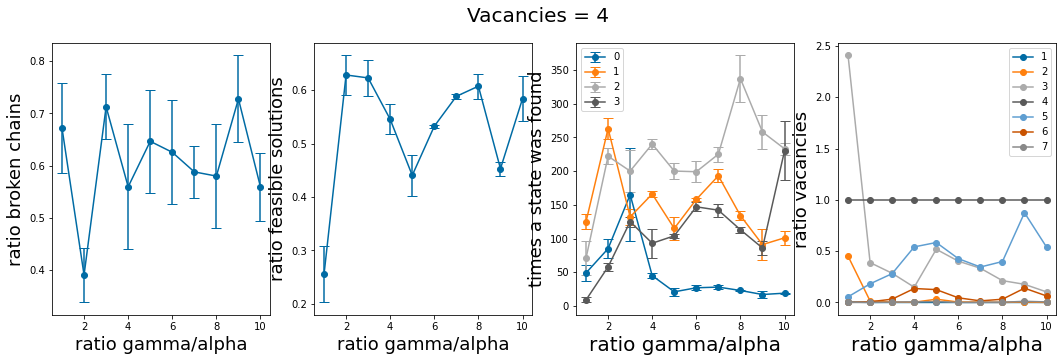

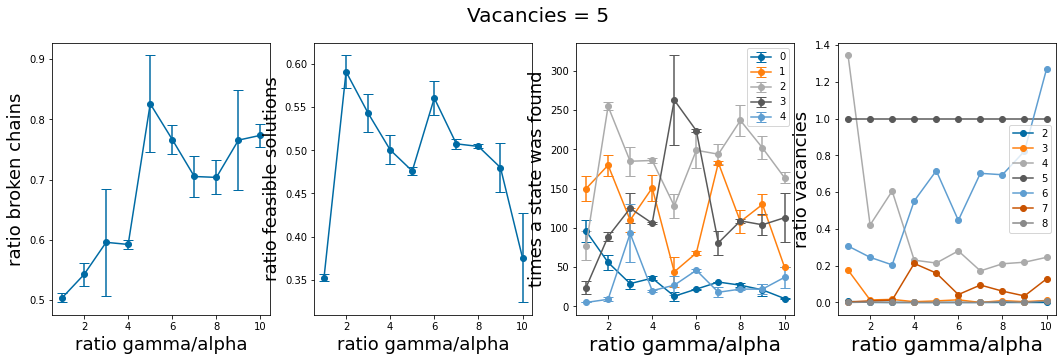

In [129]:
import matplotlib.pyplot as plt
np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

df_results = make_df('./data/chain_strength/utc_0.3/')

for vac in [1,2,3,4,5]:    
    df_all = df_results[df_results['num_vacancies'] == vac]
    df_all = df_all[df_all['weight_1'] == 1.]
    df_mean = df_all[df_all['weight_1'] == 1.].groupby('ratio l/w').mean()
    fig, axs = plt.subplots(1,4,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    x = df_mean.index.values

    y1 = df_mean['broken_chains'].to_numpy()
    y2 = df_mean['ratio_feasible'].to_numpy()

    y3 = []
    y4 = []
    error_y3 = []
    error_y4 = []
    error_bc = []
    error_rf = []
    for n,k in enumerate(x):
        
        df_tmp = df_all[df_all['ratio l/w'] == k]
        
        energies = []
        for i in df_all['energy_distribution']:
            energies.extend([float(x) for x in i.split(',')])         
        all_energies = np.unique(np.array(energies))
        labels = [str(x) for x in range(len(all_energies))]
        dist_average = np.array([0]*len(all_energies))
        all_dist = []
        
        vacancies = []
        for i in df_all['vacancies']:
            vacancies.extend([float(x) for x in i.split(',')])         
        all_vacancies = np.unique(np.array(vacancies))
        labels_vac = [str(x) for x in range(len(all_vacancies))]
        dist_vac_average = np.array([0]*len(all_vacancies))
        all_vac = []
        
        error_bc.append(np.std(df_tmp['broken_chains'].to_numpy()))
        error_rf.append(np.std(df_tmp['ratio_feasible'].to_numpy()))
        for j in range(len(df_tmp['energy_distribution'].to_list())):
            distribution = []
            error = []
            v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
            v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
            for i in all_energies:
                v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
                v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
                pos = np.where(np.round(v_energy,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    distribution.append(int(v_mult[pos[0]]))
                else:
                    distribution.append(0)
            all_dist.append(distribution) 
        y3.append(np.average(np.array(all_dist),axis=0).astype(int).tolist())
        
        error_y3.append(np.std(all_dist,axis=0))
        for j in range(len(df_tmp['vacancies'].to_list())):
            vacancies = []
            error = []
            v_vacancies = np.array([float(x) for x in df_tmp['vacancies'].to_list()[j].split(',')])
            v_vac_mult = np.array([float(x) for x in df_tmp['vacancies mult'].to_list()[j].split(',')])
            
            for i in all_vacancies:
                pos = np.where(np.round(v_vacancies,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    vacancies.append(int(v_vac_mult[pos[0]]))
                else:
                    vacancies.append(0)
            all_vac.append(vacancies) 
        y4.append(np.average(np.array(all_vac),axis=0).astype(int).tolist())
        error_y4.append(np.std(all_vac,axis=0))
    y3 = np.array(y3)
    error_y3 = np.array(error_y3)
    y4 = np.array(y4)

    # Normalise wrt the vacancy ( y =1 for vacancy = 1 for all values of x)
    y4 = y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])

    # Normalise wrt the multiplicity of states
    #y4 = y4/partition_f[:y4.shape[1]]
    
    error_y4 = np.array(error_y4)
    error_y4 = error_y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])
    ##error_y4 = error_y4/np.array(np.array([error_y4[:,vac]]*error_y4.shape[1]).transpose())
    #error_y4 = error_y4/partition_f[:y4.shape[1]]
    
    for m in range(len(y3[0])):
        axs[2].errorbar(x,y3[:,m],yerr=error_y3[:,m]/2,fmt='-o',label=labels[m],capsize=5)
    
    for m in range(len(y4[0])):
        #axs[3].errorbar(x,y4[:,m],yerr=error_y4[:,m]/2,fmt='-o',color=color[m],label=int(all_vacancies[m]),capsize=5)
        axs[3].plot(x,y4[:,m],'-o',label=int(all_vacancies[m]))

    axs[2].legend()
    axs[3].legend()

    #axs[0].plot(x, y1,'-o')
    axs[0].errorbar(x, y1, yerr = np.array(error_bc)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, y2,yerr = np.array(error_rf)/2,fmt='-o',capsize=5)

    axs[0].set_xlabel('ratio gamma/alpha', fontsize=18)
    axs[1].set_xlabel('ratio gamma/alpha', fontsize=18)
    axs[2].set_xlabel('ratio gamma/alpha', fontsize=20)
    axs[3].set_xlabel('ratio gamma/alpha', fontsize=20)
    axs[0].set_ylabel('ratio broken chains', fontsize=18)
    axs[1].set_ylabel('ratio feasible solutions', fontsize=18)
    axs[2].set_ylabel('times a state was found', fontsize=18)
    axs[3].set_ylabel('ratio vacancies', fontsize=18)
       
    #fig.set_title('All feasible',fontsize=20)

#axs[:].set_xticks(np.arange(0,25))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

#fig.set_size_inches(15.5, 7.5)

plt.show()

### chain strength 

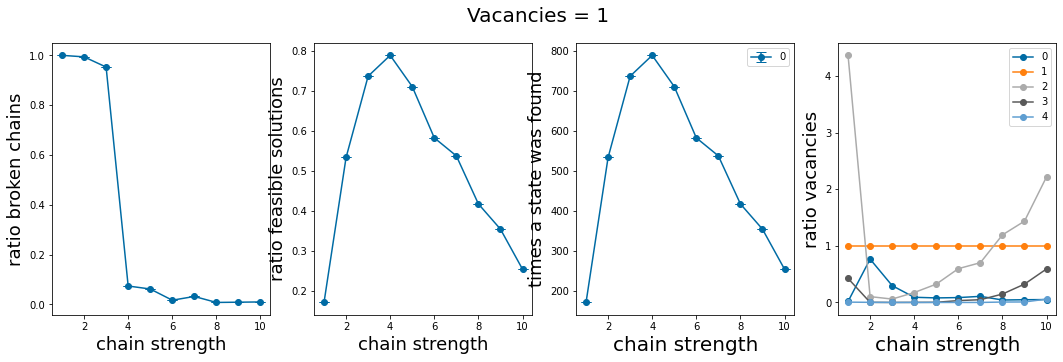

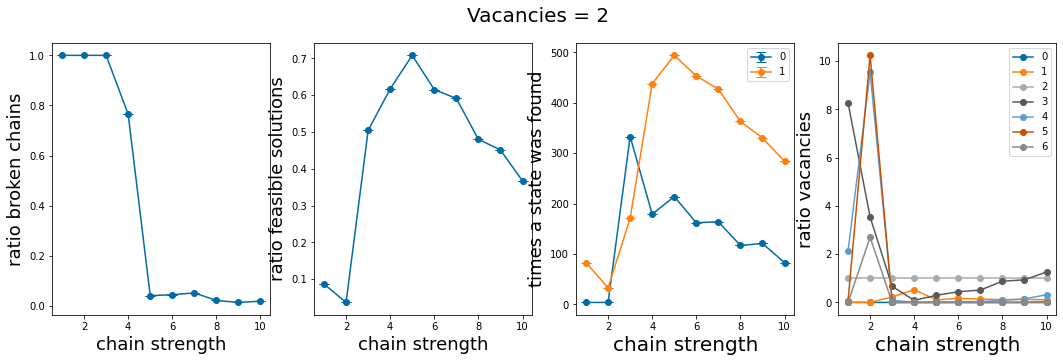

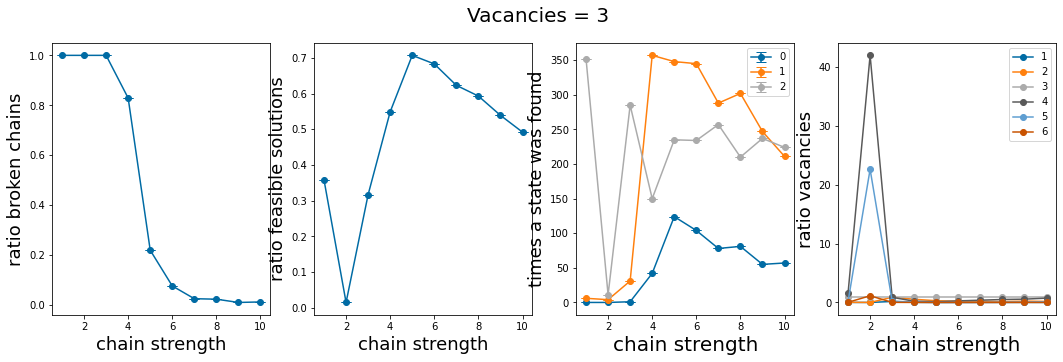

In [121]:
#FEASIBLE
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')


df_results = make_df('./data/chain_strength/')
for vac in [1,2,3]:
    df_all = df_results[df_results['num_vacancies'] == vac]
    df_all = df_all[df_all['weight_1'] == 1]
    df_mean = df_all[df_all['weight_1'] == 1].groupby('chain_strength').mean()
    fig, axs = plt.subplots(1,4,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    x = df_mean.index.values

    y1 = df_mean['broken_chains'].to_numpy()
    y2 = df_mean['ratio_feasible'].to_numpy()

    y3 = []
    y4 = []
    error_y3 = []
    error_y4 = []
    error_bc = []
    error_rf = []
    for n,k in enumerate(x):
        df_tmp = df_all[df_all['chain_strength'] == k]
        energies = []
        for i in df_all['energy_distribution']:
            energies.extend([float(x) for x in i.split(',')])         
        all_energies = np.unique(np.array(energies))
        labels = [str(x) for x in range(len(all_energies))]
        dist_average = np.array([0]*len(all_energies))
        all_dist = []
        
        vacancies = []
        for i in df_all['vacancies']:
            vacancies.extend([float(x) for x in i.split(',')])         
        all_vacancies = np.unique(np.array(vacancies))
        labels_vac = [str(x) for x in range(len(all_vacancies))]
        dist_vac_average = np.array([0]*len(all_vacancies))
        all_vac = []
        
        error_bc.append(np.std(df_tmp['broken_chains'].to_numpy()))
        error_rf.append(np.std(df_tmp['ratio_feasible'].to_numpy()))
        for j in range(len(df_tmp['energy_distribution'].to_list())):
            distribution = []
            error = []
            v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
            v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
            for i in all_energies:
                v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
                v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
                pos = np.where(np.round(v_energy,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    distribution.append(int(v_mult[pos[0]]))
                else:
                    distribution.append(0)
            all_dist.append(distribution) 
        y3.append(np.average(np.array(all_dist),axis=0).astype(int).tolist())
        
        error_y3.append(np.std(all_dist,axis=0))
        for j in range(len(df_tmp['vacancies'].to_list())):
            vacancies = []
            error = []
            v_vacancies = np.array([float(x) for x in df_tmp['vacancies'].to_list()[j].split(',')])
            v_vac_mult = np.array([float(x) for x in df_tmp['vacancies mult'].to_list()[j].split(',')])
            
            for i in all_vacancies:
                pos = np.where(np.round(v_vacancies,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    vacancies.append(int(v_vac_mult[pos[0]]))
                else:
                    vacancies.append(0)
            all_vac.append(vacancies) 
        y4.append(np.average(np.array(all_vac),axis=0).astype(int).tolist())
        error_y4.append(np.std(all_vac,axis=0))
    y3 = np.array(y3)
    error_y3 = np.array(error_y3)
    y4 = np.array(y4)

    # Normalise wrt the vacancy ( y =1 for vacancy = 1 for all values of x)
    y4 = y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])

    # Normalise wrt the multiplicity of states
    #y4 = y4/partition_f[:y4.shape[1]]
    
    error_y4 = np.array(error_y4)
    error_y4 = error_y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])
    ##error_y4 = error_y4/np.array(np.array([error_y4[:,vac]]*error_y4.shape[1]).transpose())
    #error_y4 = error_y4/partition_f[:y4.shape[1]]
    
    for m in range(len(y3[0])):
        axs[2].errorbar(x,y3[:,m],yerr=error_y3[:,m]/2,fmt='-o',label=labels[m],capsize=5)
    
    for m in range(len(y4[0])):
        #axs[3].errorbar(x,y4[:,m],yerr=error_y4[:,m]/2,fmt='-o',label=int(all_vacancies[m]),capsize=5)
        axs[3].plot(x,y4[:,m],'-o',label=int(all_vacancies[m]))

    axs[2].legend()
    axs[3].legend()

    #axs[0].plot(x, y1,'-o')
    axs[0].errorbar(x, y1, yerr = np.array(error_bc)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, y2,yerr = np.array(error_rf)/2,fmt='-o',capsize=5)

    axs[0].set_xlabel('chain strength', fontsize=18)
    axs[1].set_xlabel('chain strength', fontsize=18)
    axs[2].set_xlabel('chain strength', fontsize=20)
    axs[3].set_xlabel('chain strength', fontsize=20)
    axs[0].set_ylabel('ratio broken chains', fontsize=18)
    axs[1].set_ylabel('ratio feasible solutions', fontsize=18)
    axs[2].set_ylabel('times a state was found', fontsize=18)
    axs[3].set_ylabel('ratio vacancies', fontsize=18)
       
    #fig.set_title('All feasible',fontsize=20)

#axs[:].set_xticks(np.arange(0,25))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

#fig.set_size_inches(15.5, 7.5)

plt.show()

### chain strength - scaled

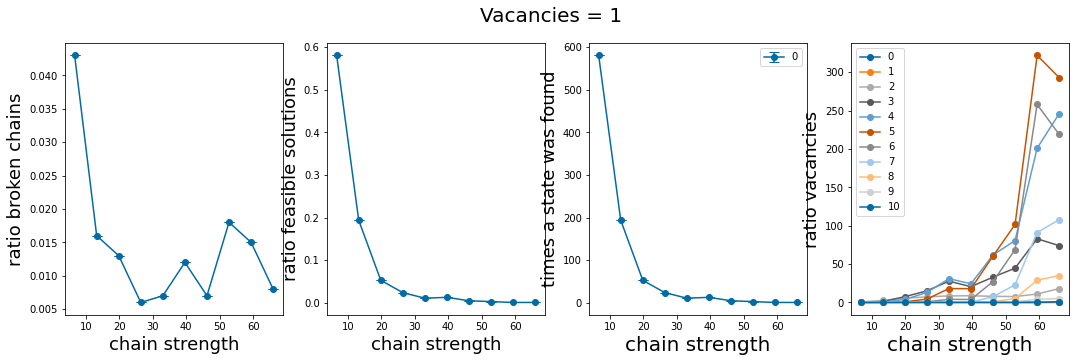

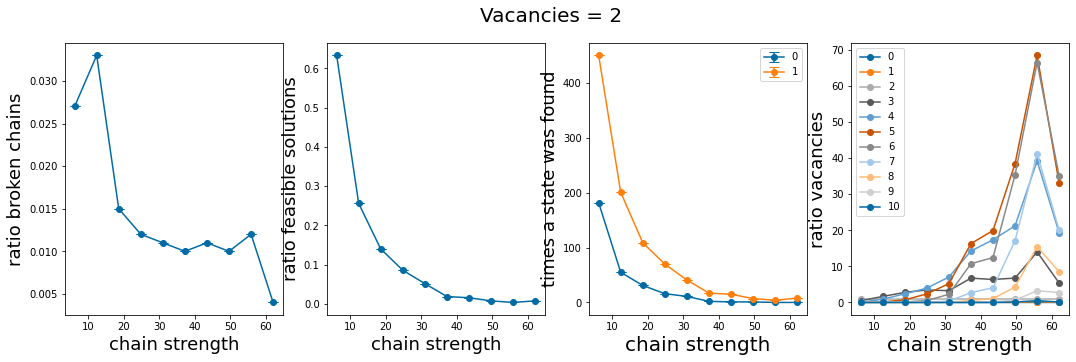

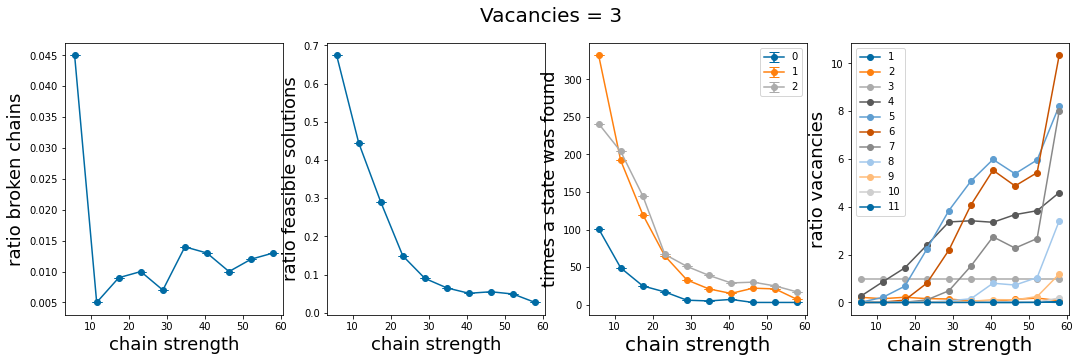

In [118]:
#FEASIBLE
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange',]
point = ['-o','^','s']

plt.style.use('tableau-colorblind10')

df_results = make_df('./data/chain_strength/scaled/')

for vac in [1,2,3]:
    df_all = df_results[df_results['num_vacancies'] == vac]
    df_all = df_all[df_all['weight_1'] == 1]
    df_mean = df_all[df_all['weight_1'] == 1].groupby('chain_strength').mean()
    fig, axs = plt.subplots(1,4,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    x = df_mean.index.values

    y1 = df_mean['broken_chains'].to_numpy()
    y2 = df_mean['ratio_feasible'].to_numpy()

    y3 = []
    y4 = []
    error_y3 = []
    error_y4 = []
    error_bc = []
    error_rf = []
    for n,k in enumerate(x):
        df_tmp = df_all[df_all['chain_strength'] == k]
        energies = []
        for i in df_all['energy_distribution']:
            energies.extend([float(x) for x in i.split(',')])         
        all_energies = np.unique(np.array(energies))
        labels = [str(x) for x in range(len(all_energies))]
        dist_average = np.array([0]*len(all_energies))
        all_dist = []
        
        vacancies = []
        for i in df_all['vacancies']:
            vacancies.extend([float(x) for x in i.split(',')])         
        all_vacancies = np.unique(np.array(vacancies))
        labels_vac = [str(x) for x in range(len(all_vacancies))]
        dist_vac_average = np.array([0]*len(all_vacancies))
        all_vac = []
        
        error_bc.append(np.std(df_tmp['broken_chains'].to_numpy()))
        error_rf.append(np.std(df_tmp['ratio_feasible'].to_numpy()))
        for j in range(len(df_tmp['energy_distribution'].to_list())):
            distribution = []
            error = []
            v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
            v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
            for i in all_energies:
                v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
                v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
                pos = np.where(np.round(v_energy,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    distribution.append(int(v_mult[pos[0]]))
                else:
                    distribution.append(0)
            all_dist.append(distribution) 
        y3.append(np.average(np.array(all_dist),axis=0).astype(int).tolist())
        
        error_y3.append(np.std(all_dist,axis=0))
        for j in range(len(df_tmp['vacancies'].to_list())):
            vacancies = []
            error = []
            v_vacancies = np.array([float(x) for x in df_tmp['vacancies'].to_list()[j].split(',')])
            v_vac_mult = np.array([float(x) for x in df_tmp['vacancies mult'].to_list()[j].split(',')])
            
            for i in all_vacancies:
                pos = np.where(np.round(v_vacancies,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    vacancies.append(int(v_vac_mult[pos[0]]))
                else:
                    vacancies.append(0)
            all_vac.append(vacancies) 
        y4.append(np.average(np.array(all_vac),axis=0).astype(int).tolist())
        error_y4.append(np.std(all_vac,axis=0))
    y3 = np.array(y3)
    error_y3 = np.array(error_y3)
    y4 = np.array(y4)

    # Normalise wrt the vacancy ( y =1 for vacancy = 1 for all values of x)
    y4 = y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])

    # Normalise wrt the multiplicity of states
    #y4 = y4/partition_f[:y4.shape[1]]
    
    error_y4 = np.array(error_y4)
    error_y4 = error_y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])
    ##error_y4 = error_y4/np.array(np.array([error_y4[:,vac]]*error_y4.shape[1]).transpose())
    #error_y4 = error_y4/partition_f[:y4.shape[1]]
    
    for m in range(len(y3[0])):
        axs[2].errorbar(x,y3[:,m],yerr=error_y3[:,m]/2,fmt='-o',label=labels[m],capsize=5)
    
    for m in range(len(y4[0])):
        #axs[3].errorbar(x,y4[:,m],yerr=error_y4[:,m]/2,fmt='-o',color=color[m],label=int(all_vacancies[m]),capsize=5)
        axs[3].plot(x,y4[:,m],'-o',label=int(all_vacancies[m]))

    axs[2].legend()
    axs[3].legend()

    #axs[0].plot(x, y1,'-o')
    axs[0].errorbar(x, y1, yerr = np.array(error_bc)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, y2,yerr = np.array(error_rf)/2,fmt='-o',capsize=5)

    axs[0].set_xlabel('chain strength', fontsize=18)
    axs[1].set_xlabel('chain strength', fontsize=18)
    axs[2].set_xlabel('chain strength', fontsize=20)
    axs[3].set_xlabel('chain strength', fontsize=20)
    axs[0].set_ylabel('ratio broken chains', fontsize=18)
    axs[1].set_ylabel('ratio feasible solutions', fontsize=18)
    axs[2].set_ylabel('times a state was found', fontsize=18)
    axs[3].set_ylabel('ratio vacancies', fontsize=18)
       
    #fig.set_title('All feasible',fontsize=20)

#axs[:].set_xticks(np.arange(0,25))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

#fig.set_size_inches(15.5, 7.5)

plt.show()

### chain strength - uniform torque compensation

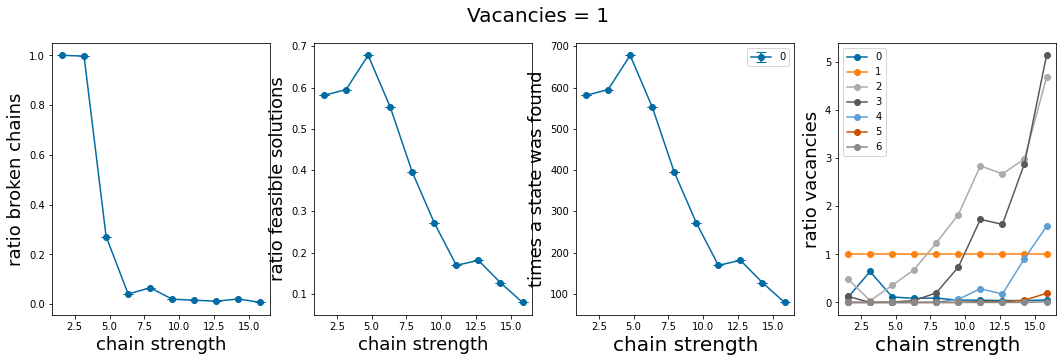

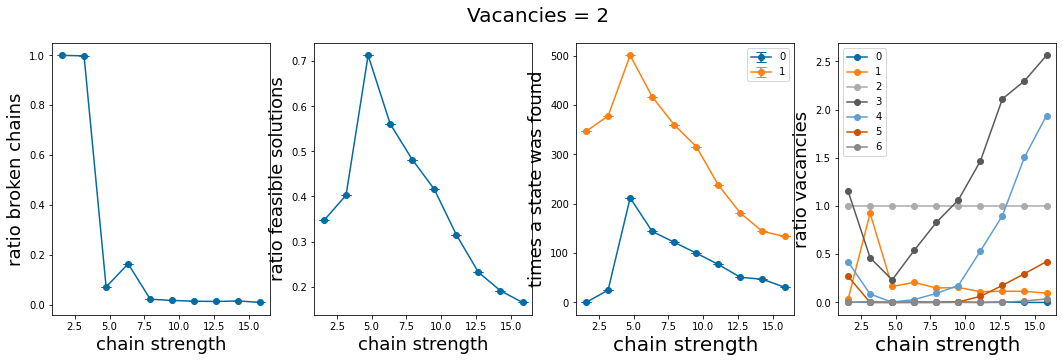

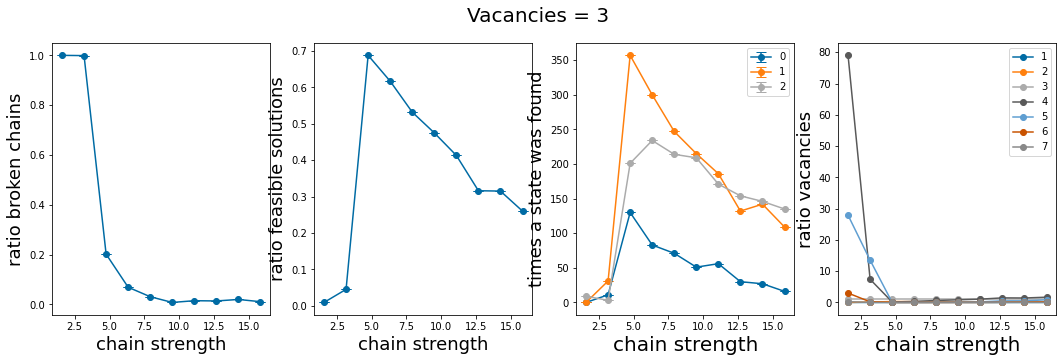

In [119]:
#FEASIBLE
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange',]
point = ['-o','^','s']

plt.style.use('tableau-colorblind10')

df_results = make_df('./data/chain_strength/utc')

for vac in [1,2,3]:
    df_all = df_results[df_results['num_vacancies'] == vac]
    df_all = df_all[df_all['weight_1'] == 1]
    df_mean = df_all[df_all['weight_1'] == 1].groupby('chain_strength').mean()
    fig, axs = plt.subplots(1,4,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    x = df_mean.index.values

    y1 = df_mean['broken_chains'].to_numpy()
    y2 = df_mean['ratio_feasible'].to_numpy()

    y3 = []
    y4 = []
    error_y3 = []
    error_y4 = []
    error_bc = []
    error_rf = []
    for n,k in enumerate(x):
        df_tmp = df_all[df_all['chain_strength'] == k]
        energies = []
        for i in df_all['energy_distribution']:
            energies.extend([float(x) for x in i.split(',')])         
        all_energies = np.unique(np.array(energies))
        labels = [str(x) for x in range(len(all_energies))]
        dist_average = np.array([0]*len(all_energies))
        all_dist = []
        
        vacancies = []
        for i in df_all['vacancies']:
            vacancies.extend([float(x) for x in i.split(',')])         
        all_vacancies = np.unique(np.array(vacancies))
        labels_vac = [str(x) for x in range(len(all_vacancies))]
        dist_vac_average = np.array([0]*len(all_vacancies))
        all_vac = []
        
        error_bc.append(np.std(df_tmp['broken_chains'].to_numpy()))
        error_rf.append(np.std(df_tmp['ratio_feasible'].to_numpy()))
        for j in range(len(df_tmp['energy_distribution'].to_list())):
            distribution = []
            error = []
            v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
            v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
            for i in all_energies:
                v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
                v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
                pos = np.where(np.round(v_energy,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    distribution.append(int(v_mult[pos[0]]))
                else:
                    distribution.append(0)
            all_dist.append(distribution) 
        y3.append(np.average(np.array(all_dist),axis=0).astype(int).tolist())
        
        error_y3.append(np.std(all_dist,axis=0))
        for j in range(len(df_tmp['vacancies'].to_list())):
            vacancies = []
            error = []
            v_vacancies = np.array([float(x) for x in df_tmp['vacancies'].to_list()[j].split(',')])
            v_vac_mult = np.array([float(x) for x in df_tmp['vacancies mult'].to_list()[j].split(',')])
            
            for i in all_vacancies:
                pos = np.where(np.round(v_vacancies,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    vacancies.append(int(v_vac_mult[pos[0]]))
                else:
                    vacancies.append(0)
            all_vac.append(vacancies) 
        y4.append(np.average(np.array(all_vac),axis=0).astype(int).tolist())
        error_y4.append(np.std(all_vac,axis=0))
    y3 = np.array(y3)
    error_y3 = np.array(error_y3)
    y4 = np.array(y4)

    # Normalise wrt the vacancy ( y =1 for vacancy = 1 for all values of x)
    y4 = y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])

    # Normalise wrt the multiplicity of states
    #y4 = y4/partition_f[:y4.shape[1]]
    
    error_y4 = np.array(error_y4)
    error_y4 = error_y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])
    ##error_y4 = error_y4/np.array(np.array([error_y4[:,vac]]*error_y4.shape[1]).transpose())
    #error_y4 = error_y4/partition_f[:y4.shape[1]]
    
    for m in range(len(y3[0])):
        axs[2].errorbar(x,y3[:,m],yerr=error_y3[:,m]/2,fmt='-o',label=labels[m],capsize=5)
    
    for m in range(len(y4[0])):
        #axs[3].errorbar(x,y4[:,m],yerr=error_y4[:,m]/2,fmt='-o',color=color[m],label=int(all_vacancies[m]),capsize=5)
        axs[3].plot(x,y4[:,m],'-o',label=int(all_vacancies[m]))

    axs[2].legend()
    axs[3].legend()

    #axs[0].plot(x, y1,'-o')
    axs[0].errorbar(x, y1, yerr = np.array(error_bc)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, y2,yerr = np.array(error_rf)/2,fmt='-o',capsize=5)

    axs[0].set_xlabel('chain strength', fontsize=18)
    axs[1].set_xlabel('chain strength', fontsize=18)
    axs[2].set_xlabel('chain strength', fontsize=20)
    axs[3].set_xlabel('chain strength', fontsize=20)
    axs[0].set_ylabel('ratio broken chains', fontsize=18)
    axs[1].set_ylabel('ratio feasible solutions', fontsize=18)
    axs[2].set_ylabel('times a state was found', fontsize=18)
    axs[3].set_ylabel('ratio vacancies', fontsize=18)
       
    #fig.set_title('All feasible',fontsize=20)

#axs[:].set_xticks(np.arange(0,25))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

#fig.set_size_inches(15.5, 7.5)

plt.show()

# anneal time

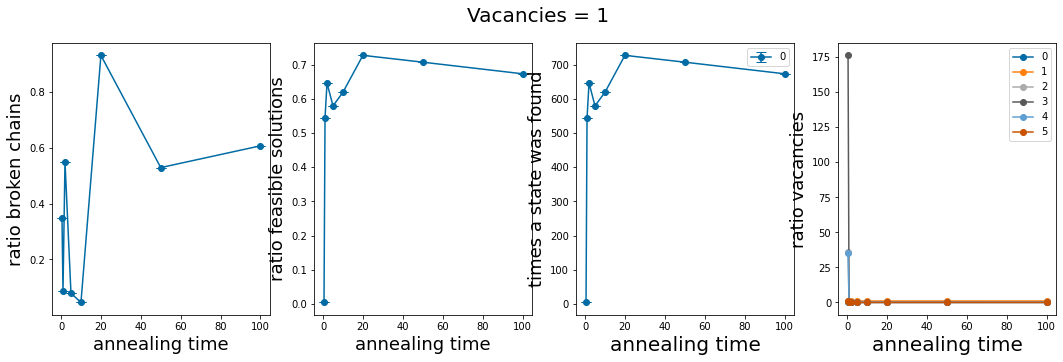

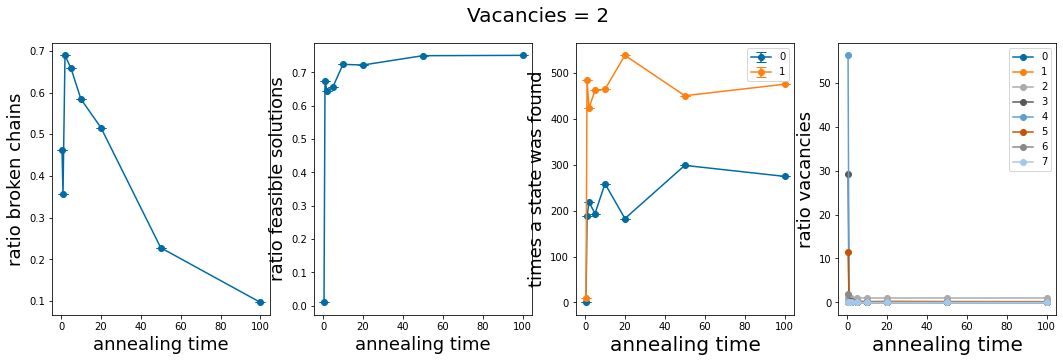

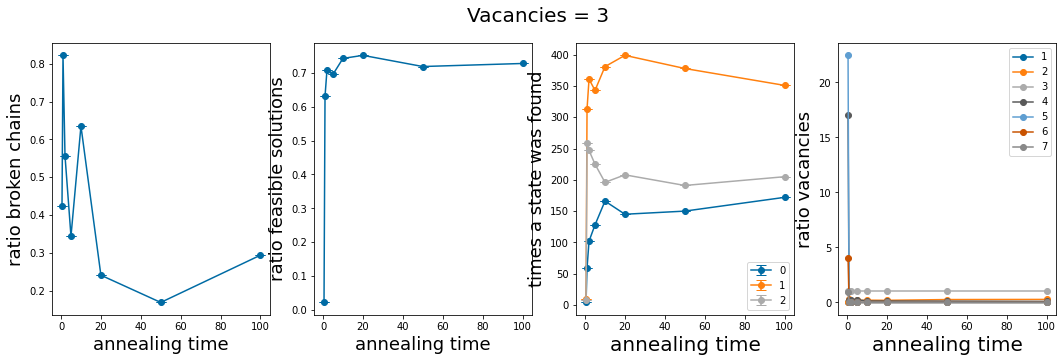

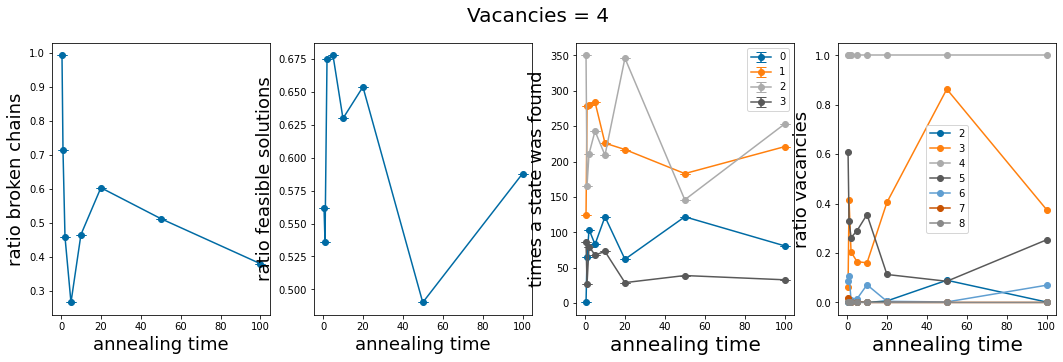

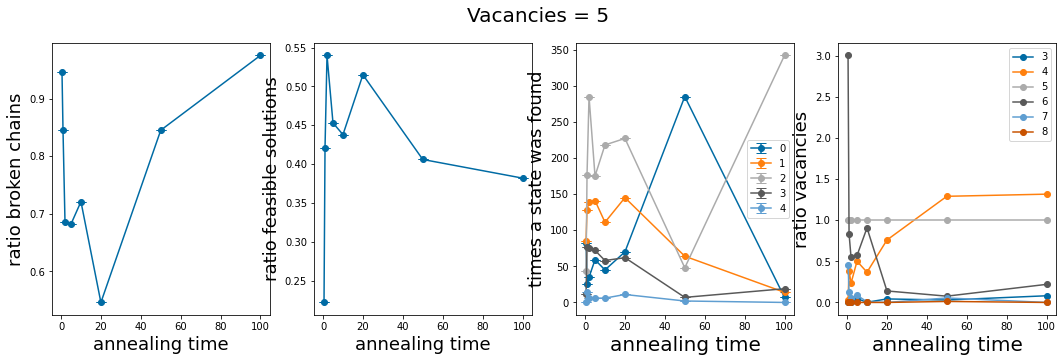

In [30]:
#FEASIBLE
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange',]
point = ['-o','^','s']

plt.style.use('tableau-colorblind10')

df_results = make_df('./data/anneal_time/')

for vac in [1,2,3,4,5]:
    df_all = df_results[df_results['num_vacancies'] == vac]
    df_all = df_all[df_all['weight_1'] == 1]
    df_mean = df_all[df_all['weight_1'] == 1].groupby('qpu_anneal_time_per_sample').mean()
    fig, axs = plt.subplots(1,4,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    x = df_mean.index.values

    y1 = df_mean['broken_chains'].to_numpy()
    y2 = df_mean['ratio_feasible'].to_numpy()

    y3 = []
    y4 = []
    error_y3 = []
    error_y4 = []
    error_bc = []
    error_rf = []
    for n,k in enumerate(x):
        df_tmp = df_all[df_all['qpu_anneal_time_per_sample'] == k]
        energies = []
        for i in df_all['energy_distribution']:
            energies.extend([float(x) for x in i.split(',')])         
        all_energies = np.unique(np.array(energies))
        labels = [str(x) for x in range(len(all_energies))]
        dist_average = np.array([0]*len(all_energies))
        all_dist = []
        
        vacancies = []
        for i in df_all['vacancies']:
            vacancies.extend([float(x) for x in i.split(',')])         
        all_vacancies = np.unique(np.array(vacancies))
        labels_vac = [str(x) for x in range(len(all_vacancies))]
        dist_vac_average = np.array([0]*len(all_vacancies))
        all_vac = []
        
        error_bc.append(np.std(df_tmp['broken_chains'].to_numpy()))
        error_rf.append(np.std(df_tmp['ratio_feasible'].to_numpy()))
        for j in range(len(df_tmp['energy_distribution'].to_list())):
            distribution = []
            error = []
            v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
            v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
            for i in all_energies:
                v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
                v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
                pos = np.where(np.round(v_energy,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    distribution.append(int(v_mult[pos[0]]))
                else:
                    distribution.append(0)
            all_dist.append(distribution) 
        y3.append(np.average(np.array(all_dist),axis=0).astype(int).tolist())
        
        error_y3.append(np.std(all_dist,axis=0))
        for j in range(len(df_tmp['vacancies'].to_list())):
            vacancies = []
            error = []
            v_vacancies = np.array([float(x) for x in df_tmp['vacancies'].to_list()[j].split(',')])
            v_vac_mult = np.array([float(x) for x in df_tmp['vacancies mult'].to_list()[j].split(',')])
            
            for i in all_vacancies:
                pos = np.where(np.round(v_vacancies,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    vacancies.append(int(v_vac_mult[pos[0]]))
                else:
                    vacancies.append(0)
            all_vac.append(vacancies) 
        y4.append(np.average(np.array(all_vac),axis=0).astype(int).tolist())
        error_y4.append(np.std(all_vac,axis=0))
    y3 = np.array(y3)
    error_y3 = np.array(error_y3)
    y4 = np.array(y4)

    # Normalise wrt the vacancy ( y =1 for vacancy = 1 for all values of x)
    y4 = y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])

    # Normalise wrt the multiplicity of states
    #y4 = y4/partition_f[:y4.shape[1]]
    
    error_y4 = np.array(error_y4)
    error_y4 = error_y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])
    ##error_y4 = error_y4/np.array(np.array([error_y4[:,vac]]*error_y4.shape[1]).transpose())
    #error_y4 = error_y4/partition_f[:y4.shape[1]]
    
    for m in range(len(y3[0])):
        axs[2].errorbar(x,y3[:,m],yerr=error_y3[:,m]/2,fmt='-o',label=labels[m],capsize=5)
    
    for m in range(len(y4[0])):
        #axs[3].errorbar(x,y4[:,m],yerr=error_y4[:,m]/2,fmt='-o',color=color[m],label=int(all_vacancies[m]),capsize=5)
        axs[3].plot(x,y4[:,m],'-o',label=int(all_vacancies[m]))

    axs[2].legend()
    axs[3].legend()

    #axs[0].plot(x, y1,'-o')
    axs[0].errorbar(x, y1, yerr = np.array(error_bc)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, y2,yerr = np.array(error_rf)/2,fmt='-o',capsize=5)

    axs[0].set_xlabel('annealing time', fontsize=18)
    axs[1].set_xlabel('annealing time', fontsize=18)
    axs[2].set_xlabel('annealing time', fontsize=20)
    axs[3].set_xlabel('annealing time', fontsize=20)
    axs[0].set_ylabel('ratio broken chains', fontsize=18)
    axs[1].set_ylabel('ratio feasible solutions', fontsize=18)
    axs[2].set_ylabel('times a state was found', fontsize=18)
    axs[3].set_ylabel('ratio vacancies', fontsize=18)
       
    #fig.set_title('All feasible',fontsize=20)

#axs[:].set_xticks(np.arange(0,25))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

#fig.set_size_inches(15.5, 7.5)

plt.show()

$$
x = \sum_{i=0}^{N_{sites}} x_{i}  = x_{1} + x_{2} + ... + x_{N}
$$

## Cell size

In [117]:
df_results = make_df('./data/cell_size')
a

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,chain_break_fraction,energy,num_occurrences
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,1,1,0.000000,-24.0,18
1,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,0.000000,-24.0,45
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,0.000000,-24.0,14
3,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,0.000000,-24.0,11
4,1,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,0.000000,-24.0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,0.055556,-18.0,1
248,1,1,1,0,1,1,1,1,1,1,...,1,0,1,1,0,1,1,0.055556,-3.0,1
249,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,0,1,0.055556,-17.0,1
250,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,0,0,0.055556,-2.0,1


In [144]:
a = load_json('data/test/graphene_C18_bqm_v1_cF_w11_w20_l2_r1000_t0_1658402871.json')[0]
a.iloc[:,a.columns != 'chain_break_fraction'].sort_values(by='energy').tail(50)
for i in np.unique(np.sum(a.iloc[:,:18].to_numpy(),axis=1)):
    print(i,np.sum(a['num_occurrences'].to_numpy()[np.where(np.sum(a.iloc[:,:18].to_numpy(),axis=1) == i)[0]]))

15 10
16 313
17 624
18 53


In [170]:
a = load_json('data/test/graphene_C18_bqm_v1_cF_w11_w20_l10_r1000_t0_1658247011.json')[0]
a = load_json('data/tmp/graphene_C8_bqm_v1_cF_w11_w20_l10_r1000_t0_1660032780.json')[0]
a.iloc[:,a.columns != 'chain_break_fraction'].sort_values(by='energy').tail(50)
for i in np.unique(np.sum(a.iloc[:,:8].to_numpy(),axis=1)):
    print(i,np.sum(a['num_occurrences'].to_numpy()[np.where(np.sum(a.iloc[:,:8].to_numpy(),axis=1) == i)[0]]))

6 94
7 897
8 9


In [157]:
qubo_m = load_json('data/cell_size/graphene_C8_bqm_v1_cF_w11_w20_l2_r1000_t0_1659955139.json')[2]
#qubo_m = load_json('data/test/graphene_C18_bqm_v1_cF_w11_w20_l10_r1000_t0_1658247011.json')[2]
#qubo_m = load_json('data/test/graphene_C18_bqm_v1_cF_w11_w20_l2_r1000_t0_1658402871.json')[2]
qubo_m = np.array(qubo_m).reshape(int(np.sqrt(len(qubo_m))),int(np.sqrt(len(qubo_m))))

In [158]:
classical_solver(8,qubo_m)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]),
 array([   0,  -26,  -26,  -26,  -26,  -26,  -26,  -26,  -26,  -49,  -49,
         -48,  -49,  -48,  -49,  -48,  -48,  -49,  -48,  -49,  -48,  -49,
         -49,  -48,  -49,  -48,  -49,  -48,  -48,  -48,  -49,  -48,  -49,
         -48,  -48,  -48,  -48,  -67,  -68,  -67,  -68,  -66,  -68,  -67,
         -66,  -68,  -68,  -67,  -68,  -68,  -67,  -67,  -68,  -67,  -68,
         -67,  -68,  -67,  -68,  -67,  -67,  -66,  -68,  -67,  -67,  -66,
         -67,  -68,  -68,  -68,  -67,  -67,  -67,  -68,  -68,  -68,  -67,
         -68,  -66,  -66,  -67,  -66,  -67,  -68,  -67,  -68,  -67,  -68,
         -67,  -67,  -68,  -68,  -66,  -82,  -84,  -82,  -83,  -83,  -82,
         -83,  -82,  -82,  -83,  -84,  -83,  -83,  -83,  -82,  -82,  -83,
         -83,  -83,  -83,  -82,  -83,  -84,  -8

In [155]:
x_classical = np.array([1]*18)
x_classical[0] = 0
x_classical[1] = 0
E_tmp = np.matmul(x_classical,qubo_m)
E_classical = np.sum(x_classical*E_tmp)
E_classical

-597

In [180]:
df_results = make_df('./data/cell_ratio')
np.unique(df_results['N atoms'].to_numpy())

array([8, 18, 32, 50, 72], dtype=object)

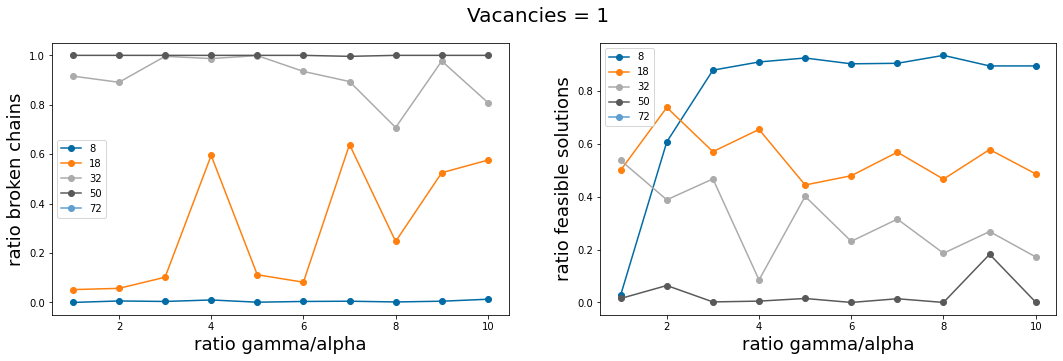

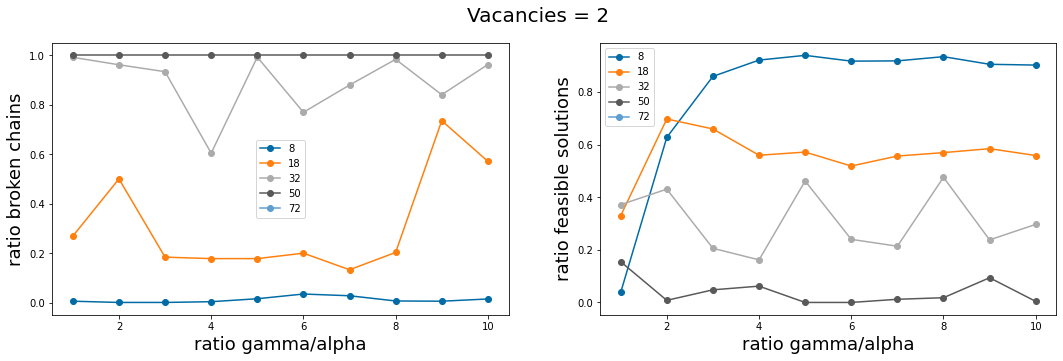

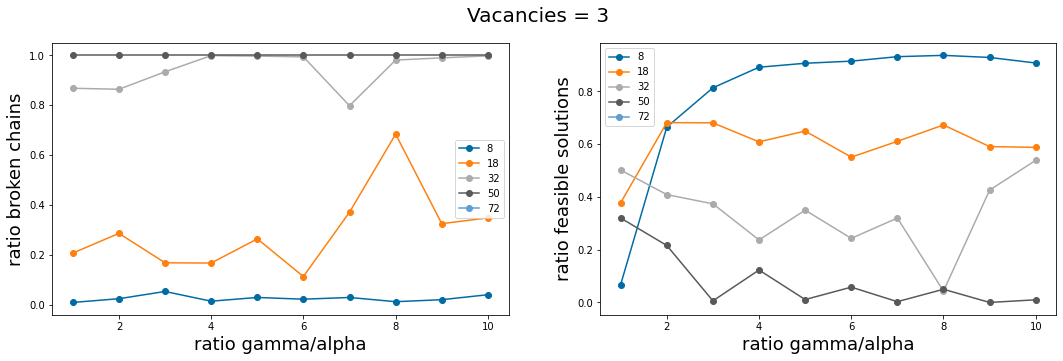

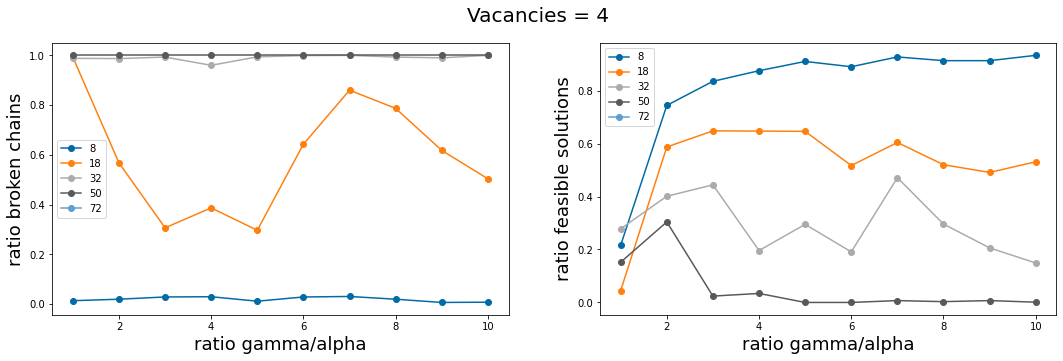

In [504]:
#Plot in the same graph feasible vs ratio for different cell sizes
import matplotlib.pyplot as plt
np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

df_results = make_df('./data/cell_ratio')
for vac in [1,2,3,4]:        
    fig, axs = plt.subplots(1,2,figsize=(18, 5), sharey=False)
    for n_atoms in [8, 18, 32, 50, 72]:
        df_all = df_results[df_results['num_vacancies'] == vac]
        df_mean = df_all[df_all['N atoms'] == n_atoms].groupby('ratio l/w').mean()

        fig.suptitle('Vacancies = %s'%vac, fontsize=20)

        x = df_mean.index.values

        y1 = df_mean['broken_chains'].to_numpy()
        y2 = df_mean['ratio_feasible'].to_numpy()
        
        axs[0].plot(x, y1, '-o', label=str(n_atoms))
        axs[1].plot(x, y2, '-o', label=str(n_atoms))
        axs[0].legend()
        axs[1].legend()

    

    axs[0].set_xlabel('ratio gamma/alpha', fontsize=18)
    axs[1].set_xlabel('ratio gamma/alpha', fontsize=18)
    '''axs[2].set_xlabel('ratio gamma/alpha', fontsize=20)
    axs[3].set_xlabel('ratio gamma/alpha', fontsize=20)'''
    axs[0].set_ylabel('ratio broken chains', fontsize=18)
    axs[1].set_ylabel('ratio feasible solutions', fontsize=18)
    '''axs[2].set_ylabel('times a state was found', fontsize=18)
    axs[3].set_ylabel('ratio vacancies', fontsize=18)'''
       
    #fig.set_title('All feasible',fontsize=20)

#axs[:].set_xticks(np.arange(0,25))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

#fig.set_size_inches(15.5, 7.5)

plt.show()

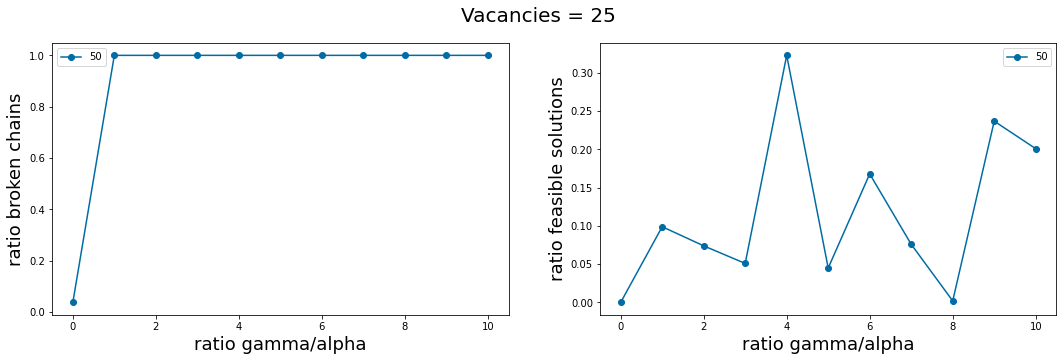

In [508]:
#LARGE CELL
import matplotlib.pyplot as plt
np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

df_results = make_df('./data/large/')
for vac in [25]:        
    fig, axs = plt.subplots(1,2,figsize=(18, 5), sharey=False)
    for n_atoms in [50]:
        df_all = df_results[df_results['num_vacancies'] == vac]
        df_mean = df_all[df_all['N atoms'] == n_atoms].groupby('ratio l/w').mean()

        fig.suptitle('Vacancies = %s'%vac, fontsize=20)

        x = df_mean.index.values

        y1 = df_mean['broken_chains'].to_numpy()
        y2 = df_mean['ratio_feasible'].to_numpy()
        
        axs[0].plot(x, y1, '-o', label=str(n_atoms))
        axs[1].plot(x, y2, '-o', label=str(n_atoms))
        axs[0].legend()
        axs[1].legend()

    

    axs[0].set_xlabel('ratio gamma/alpha', fontsize=18)
    axs[1].set_xlabel('ratio gamma/alpha', fontsize=18)
    '''axs[2].set_xlabel('ratio gamma/alpha', fontsize=20)
    axs[3].set_xlabel('ratio gamma/alpha', fontsize=20)'''
    axs[0].set_ylabel('ratio broken chains', fontsize=18)
    axs[1].set_ylabel('ratio feasible solutions', fontsize=18)
    '''axs[2].set_ylabel('times a state was found', fontsize=18)
    axs[3].set_ylabel('ratio vacancies', fontsize=18)'''
       
    #fig.set_title('All feasible',fontsize=20)

#axs[:].set_xticks(np.arange(0,25))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

#fig.set_size_inches(15.5, 7.5)

plt.show()

In [547]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy
import numpy as np

lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

n_supercell = 3
scaling_matrix = np.identity(3)*n_supercell
scaling_matrix[2][2] = 1
graphene_supercell = copy.deepcopy(graphene)
graphene_supercell.make_supercell(scaling_matrix)
structure = graphene_supercell
graphene_supercell.num_sites

18

## Classify - symmetry analysis

In [527]:
dataframe = load_json('./data/cell_size/graphene_C18_bqm_v4_cF_w11_w20_l2_r1000_t0_1659955175.json')[0]
configurations = dataframe.iloc[:,0:18].to_numpy()
multiplicity = dataframe['num_occurrences'].to_numpy()
energies = dataframe['energy'].to_numpy()

In [510]:
np.sum(configurations,axis=1)

array([17, 17, 16, 17, 16, 17, 17, 17, 17, 16, 16, 16, 16, 16, 17, 16, 17,
       16, 16, 16, 17, 17, 16, 16, 17, 17, 16, 16, 17, 17, 17, 16, 16, 16,
       17, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 16, 16, 16, 17,
       17, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17,
       16, 16, 16, 16, 16, 16, 16, 16, 17, 16, 16, 16, 16, 16, 16, 17, 16,
       16, 16, 16, 16, 16, 17, 16, 16, 16, 16, 17, 17, 15, 17, 16, 16, 16,
       16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 16

In [528]:
all_structures = []
for config in configurations:
    structure_2 = copy.deepcopy(graphene_supercell)
    for j in np.where(config == 0)[0]:
        structure_2.replace(j,1)
    all_structures.append(structure_2)

In [529]:
len(all_structures)

703

In [530]:
from pymatgen.analysis.structure_matcher import StructureMatcher 

unique_structures = StructureMatcher().group_structures(all_structures)

In [531]:
unique_structures_label = []

for structure in all_structures:
    for i in range(len(unique_structures)):
        #print(unique_structures[i][0].composition.reduced_formula,structure.composition.reduced_formula)
        if StructureMatcher().fit(structure,unique_structures[i][0]) == True:
            unique_structures_label.append(i)
            break

In [532]:
len(unique_structures)

175

In [535]:
unique_structures_label

array([174,   1,   2, 120, 121, 122,   3,   3,   4,  22,   5, 123,  23,
       174, 174, 120, 123,   6,   7,   7,   4,  24,   4,  23,  25,  26,
         4,   8,  27,  28,  29,  30,  31,  32,  33,   4,  30,   9,  34,
        30,  35,  36,  34,  37,  38,  33,  26,  10,  11,  11,  39,  40,
        41,  11,  42,  29,  35,  43,  44,   3,   5,  40,  45,  43,  46,
        47,   9,  31,  31,   4,  48,   9,  11,  49,  50,  51,  32,   9,
        41,  52,  53,  54,  33,  55,  56,  57,  11,  58,   8,  59,  12,
        51,   7,  23,   7,  39,   4,   5,  24, 174,  13,  60,  61,  62,
         6,  63,  64,   6,  10,  65,   6,  31,  11,   9, 122, 120,  66,
        35,   4,  35, 174, 174,  49,  67,   6, 121, 122, 120, 121, 122,
       120, 120,  30,  68,  49,  66,  49,  40, 124,   8,  14,  24,  69,
        70,  71,  72,  23,  73,  74,  13,  15,  36,  16,  75,  50,  33,
        76,  77,  78,  17,  41,  23,  79,  80,  56,   6,  58,  81,  73,
        23,  18,  49,  54,  13,   5,  42,  29,  62,   6,  17,  6

In [534]:
unique_structures_label = np.array(unique_structures_label)
unique_multiplicity = []
for x in range(len(unique_structures)):
    print(multiplicity[unique_structures_label==x])
    unique_multiplicity.append(np.sum(multiplicity[unique_structures_label==x]))

[1]
[3 1 1 1]
[2 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[2 1 1 1 1 1 1 2 1 2 1]
[1 1 1 1 1 1 1 1 1]
[1 1 1 2 1 1 1 1 1 1 1 1 1]
[4 1 5 3 1 1]
[1 7 1 1 1 2 1 2 1 1 1 1 1 1 1]
[1 2 3 2 4 1 2 1 1]
[2 1 1 1 1 1 1]
[1 1 1 1 1 2 2 2 1 1]
[1 1 1 1 1 1 1 1 1 1]
[3 1 2 1 1 2 1 1 1 1]
[1]
[1]
[1 1]
[1 2 2 1 1]
[1]
[1 1 1]
[2 1]
[1]
[1 1 1]
[1 1 3 1 1 1 1 1 1 1]
[1 1 1 3 2 1]
[6 1 2 1 1 1 2 1 1 1]
[5 1 1 1 1 1]
[1 1 1 1]
[1 1 1 1 1]
[1 1 1 1 1 1 1]
[ 1  1 12  3  2  2  1  2  1  1  1  1  1  1]
[2 4 1 1 1 1 1]
[2 2 1 1 1]
[3 1 1 1 2]
[2 1 1 1 1 1 1 1 1]
[1 2 3 1 1 1 1 2 1 1 1 1]
[3 1 2 1 1 1 1]
[2]
[1 1 1 1]
[1 1]
[2 1 1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1 1]
[1 1 1 3 1]
[2 1 2 1 1]
[1 1 1 1]
[2 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1]
[1 2 1 1 1 1 2 1 1 1 1 1 1 1]
[2 1 1 1]
[1 2 1 1 1 1 1]
[8 1 1]
[2 3 1 1]
[1 1 1 4]
[2 1 1 1]
[1 1 2 2]
[1 1]
[1 1 1 1 1 1 1]
[3]
[1 1]
[1 1 1 1]
[2 2 1 1 2 1 1 1]
[4 1 1 1]
[2 1 1 1 1 1 1 1]
[1 1 1 1 2]
[3 4 1 1 1 1 1 1]
[1]
[1 1 1 1 1]
[1 1 1 1]
[1 1 1 1 1]
[1 2]
[1 1 1 1]
[1 1 1 1 1

In [503]:
for i in range(len(unique_structures)):
    print(unique_structures[i][0].composition.reduced_formula)
    view(AseAtomsAdaptor().get_atoms(unique_structures[i][0]))

HC17
HC8
HC8
HC8
HC8
HC8
HC5
HC5
HC5
HC5
HC5
HC5
HC5
HC5
HC5
HC5
HC5
HC5
HC5
HC5
H2C7
H2C7
H2C7
H2C7
H2C7
H2C7
H2C7
H2C7
H2C7
H2C7
H2C7
H2C7
H2C7
H2C7
H2C7
H2C7
H2C7
H2C7
H2C7
H2C7
H2C7
H2C7
H2C7
H2C7
H5C13
H5C13
H5C13


In [74]:
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
space_groups = []
n_irr_atoms = []
symm_structures = []
for i,structure in enumerate(all_structures):
    symm_analyzer = SpacegroupAnalyzer(structure)
    space_groups.append(symm_analyzer.get_space_group_number())
    symm_structure = symm_analyzer.get_symmetrized_structure()
    symm_structures.append(symm_structure)
    n_irr_atoms.append(len(symm_structure.equivalent_indices))
symm_structures

[SymmetrizedStructure
 Full Formula (H1 C17)
 Reduced Formula: HC17
 Spacegroup: P-6m2 (187)
 abc   :   7.403172   7.403172   8.685038
 angles:  90.000000  90.000000 120.000000
 Sites (18)
   #  SP           a         b    c  Wyckoff
 ---  ----  --------  --------  ---  ---------
   0  C     0.111111  0.222222    0  3j
   1  C     0.111111  0.555556    0  3j
   2  C     0.444444  0.222222    0  3j
   3  C     0.222222  0.111111    0  6l
   4  C     0.222222  0.777778    0  1a
   5  H     0.555556  0.444444    0  1c
   6  C     0.888889  0.111111    0  1e,
 SymmetrizedStructure
 Full Formula (H1 C17)
 Reduced Formula: HC17
 Spacegroup: P-6m2 (187)
 abc   :   7.403172   7.403172   8.685038
 angles:  90.000000  90.000000 120.000000
 Sites (18)
   #  SP           a         b    c  Wyckoff
 ---  ----  --------  --------  ---  ---------
   0  C     0.111111  0.222222    0  3j
   1  C     0.111111  0.888889    0  3j
   2  C     0.444444  0.222222    0  3j
   3  C     0.222222  0.111111    0  

In [211]:
def classifier2(structures, max_shell=2):
    centered_sph_coords = []
    centered_sph_coords_structure = []
    neighbours_spatial_dist = []
    neighbours_spatial_dist_all = []
    shells = np.unique(np.round(structures[0].distance_matrix[0],decimals=6),return_counts=True)[0].tolist()

    for k,structure in enumerate(structures): 
        neighbours_spatial_dist = []
        
        for j in range(structure.num_sites):
            centered_sph_coords = []
            neighbours_spatial_dist_atom = []
            
            for n in range(max_shell+1):
                atom_indices = np.where(np.round(structure.distance_matrix[j],5) == np.round(shells[n],5))[0].tolist()
                centered_sph_coords = []
                for i in atom_indices:

                    translation_vector = structure.sites[j].distance_and_image(structure.sites[i])[1]
                    new_cart_coords = structure.cart_coords[i]+(translation_vector*structure.lattice.abc)
                    centered_cart_coords = new_cart_coords-structure.cart_coords[j] 

                    centered_sph_coords.append(cart2sph(centered_cart_coords[0],centered_cart_coords[1],centered_cart_coords[2]))        

                spatial_distribution = np.argsort(np.array(centered_sph_coords)[:,1]*10 +\
                                                np.array(centered_sph_coords)[:,0])


                neighbours_spatial_dist_atom.extend((np.array(structure.atomic_numbers)[np.array(atom_indices)[spatial_distribution]]).tolist())
            neighbours_spatial_dist.append(neighbours_spatial_dist_atom)
        neighbours_spatial_dist_all.append(neighbours_spatial_dist) 
        
    #Sort
    neighbours_spatial_dist_all_sorted = []
    sorting = []

    for k,structure in enumerate(structures):
        sorted_atoms = []
        for i in range(len(neighbours_spatial_dist_all[0])):

            sorted_atoms.append(int(''.join([str(x) for x in neighbours_spatial_dist_all[k][i]])))
        sorting.append(np.argsort(np.array(sorted_atoms)))    
        neighbours_spatial_dist_all_sorted.append((np.array(neighbours_spatial_dist_all)[k][np.argsort(np.array(sorted_atoms))]).tolist())
    neighbours_spatial_dist_all_sorted = np.array(neighbours_spatial_dist_all_sorted)    

    #Slice
    neighbours_spatial_dist_all_sorted_sliced = neighbours_spatial_dist_all_sorted[:,:,1:]
    #neighbours_spatial_dist_all_sorted_sliced = neighbours_spatial_dist_all_sorted
    
    #Flatten
    n_structures = neighbours_spatial_dist_all_sorted_sliced.shape[0]
    vector_len = neighbours_spatial_dist_all_sorted_sliced.shape[1] * neighbours_spatial_dist_all_sorted_sliced.shape[2]
    neighbours_spatial_dist_all_sorted_sliced_flat = \
    np.reshape(neighbours_spatial_dist_all_sorted_sliced, [n_structures,vector_len])

    #Reduce

    return neighbours_spatial_dist_all_sorted_sliced_flat  

In [12]:
def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    el = np.arctan2(z, hxy)
    az = np.arctan2(y, x)
    if np.around(az,6) ==  np.around(2*np.pi,6) \
    or np.around(az,6) ==  -np.around(2*np.pi,6):
        az = 0.
    if np.around(az,6) < 0.:
        az = np.round(2*np.pi+az,6)
    return [round(az,6), round(el,6), round(r,6)]

### weight_1 = 10

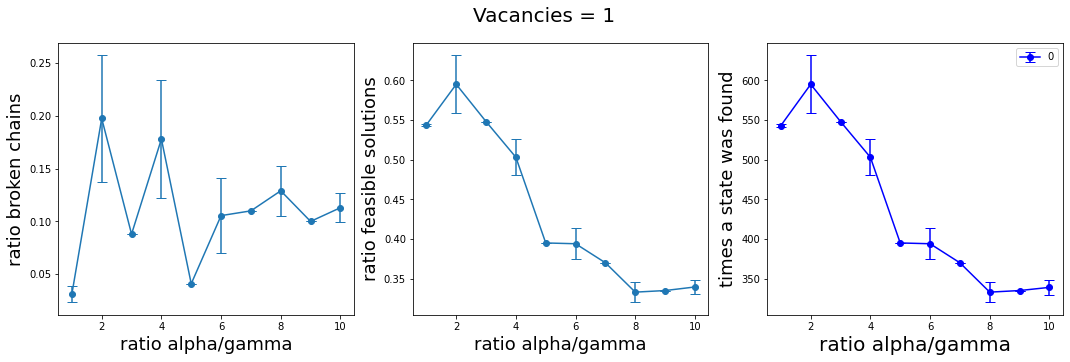

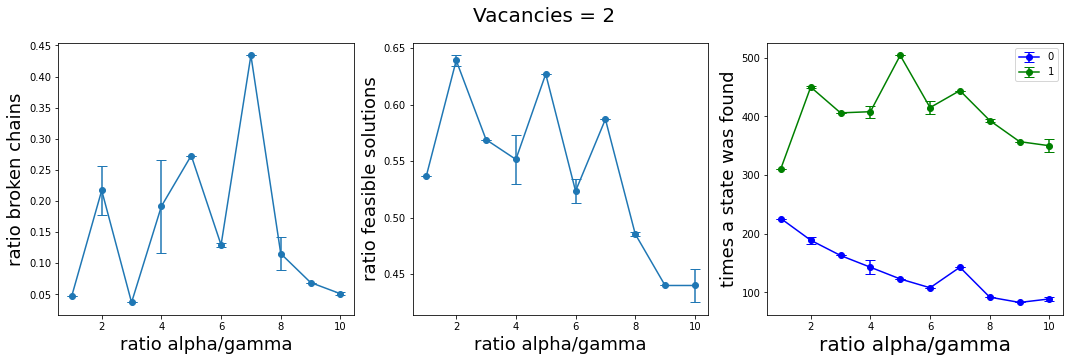

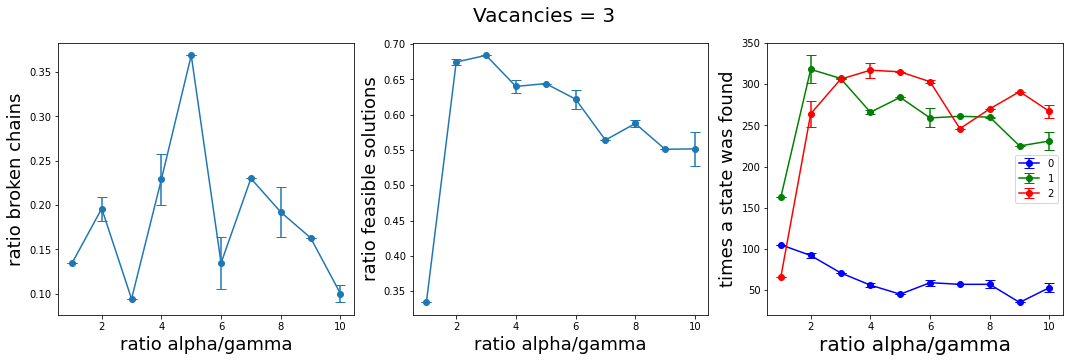

In [488]:
#FEASIBLE
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

color = ['b','g','r','c','m','y','k','tab:orange']
point = ['-o','^','s']


for vac in [1,2,3]:
    df_all = df_results[df_results['num_vacancies'] == vac]
    df_all = df_all[df_all['weight_1'] == 10]
    df_mean = df_all[df_all['weight_1'] == 10].groupby('ratio l/w').mean()
    fig, axs = plt.subplots(1,3,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    x = df_mean.index.values

    y1 = df_mean['broken_chains'].to_numpy()
    y2 = df_mean['ratio_feasible'].to_numpy()

    y3 = []
    error_y3 = []
    error_bc = []
    error_rf = []
    for n,k in enumerate(x):
        df_tmp = df_all[df_all['ratio l/w'] == k]
        #df_tmp = df_all[df_all['chain_strength'] == k]
        energies = []
        for i in df_all['energy_distribution']:
            energies.extend([float(x) for x in i.split(',')])        
        all_energies = np.unique(np.array(energies))
        labels = [str(x) for x in range(len(all_energies))]
        dist_average = np.array([0]*len(all_energies))
        all_dist = []
        #error_bc.append(np.max(df_tmp['broken_chains'].to_numpy() - np.min(df_tmp['broken_chains'].to_numpy()))
        #error_rf.append(np.max(df_tmp['ratio_feasible'].to_numpy()) - np.min(df_tmp['ratio_feasible'].to_numpy()))
        error_bc.append(np.std(df_tmp['broken_chains'].to_numpy()))
        error_rf.append(np.std(df_tmp['ratio_feasible'].to_numpy()))
        for j in range(len(df_tmp['energy_distribution'].to_list())):
            distribution = []
            error = []
            for i in all_energies:
                v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
                v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
                pos = np.where(np.round(v_energy,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    distribution.append(int(v_mult[pos[0]]))
                else:
                    distribution.append(0)
            all_dist.append(distribution) 
        y3.append(np.average(np.array(all_dist),axis=0).astype(int).tolist())
        #error_y3.append(np.max(all_dist,axis=0)-np.min(all_dist,axis=0))
        error_y3.append(np.std(all_dist,axis=0))
        #print(y3,np.max(all_dist,axis=0)-np.min(all_dist,axis=0),np.max(all_dist,axis=0),np.min(all_dist,axis=0))
    y3 = np.array(y3)
    error_y3 = np.array(error_y3)
    for m in range(len(y3[0])):
        axs[2].errorbar(x,y3[:,m],yerr=error_y3[:,m]/2,fmt='-o',label=labels[m],capsize=5)

    axs[2].legend()

    #axs[0].plot(x, y1,'-o')
    axs[0].errorbar(x, y1, yerr = np.array(error_bc)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, y2,yerr = np.array(error_rf)/2,fmt='-o',capsize=5)


    axs[0].set_xlabel('ratio gamma/alpha', fontsize=18)
    axs[1].set_xlabel('ratio gamma/alpha', fontsize=18)
    axs[2].set_xlabel('ratio gamma/alpha', fontsize=20)
    axs[0].set_ylabel('ratio broken chains', fontsize=18)
    axs[1].set_ylabel('ratio feasible solutions', fontsize=18)
    axs[2].set_ylabel('times a state was found', fontsize=18)
#fig.set_title('All feasible',fontsize=20)

#axs[:].set_xticks(np.arange(0,25))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

#fig.set_size_inches(15.5, 7.5)

plt.show()

# New method

In [805]:
num_sites = graphene_supercell.num_sites
alpha = 1
lambda_1 = 2
theta = 100
num_vac = 2
num_atoms = num_sites - num_vac
A = build_adjacency_matrix(graphene_supercell)
np.where(A==1)

(array([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,
         5,  6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11,
        11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16,
        17, 17, 17]),
 array([ 9, 10, 15, 10, 11, 16,  9, 11, 17,  9, 12, 13, 10, 13, 14, 11, 12,
        14, 12, 15, 16, 13, 16, 17, 14, 15, 17,  0,  2,  3,  0,  1,  4,  1,
         2,  5,  3,  5,  6,  3,  4,  7,  4,  5,  8,  0,  6,  8,  1,  6,  7,
         2,  7,  8]))

In [9]:
def build_qubo_discrete_vacancies(structure,num_vac, alpha = 1, lambda_1 = 2, theta=100):
    
    num_sites = structure.num_sites
    num_atoms = num_sites - num_vac
    A = build_adjacency_matrix(structure)
    
    Q = np.zeros((2*num_sites,2*num_sites))
    
    for i in range(0,2*num_sites,2): #xc
        Q[i,i] = lambda_1*(1-2*num_atoms) - theta
        #print(i,lambda_1*(1-2*num_atoms) - theta)
    for i in range(1,2*num_sites,2): #xv
        Q[i,i] = lambda_1*(1-2*num_vac) - theta
        #print(i,lambda_1*(1-2*num_vac) - theta)
    for i in range(0,2*num_sites,2): #xcxv
        Q[i,i+1] = 2*theta
        #print(i,lambda_1*(1-2*num_vac) - theta)
    for i in range(0,2*num_sites,2): 
        for j in range(i+2,2*num_sites,2):
            Q[i,j] = 2*lambda_1
    for i in range(1,2*num_sites,2): 
        for j in range(i+2,2*num_sites,2):
            Q[i,j] = 2*lambda_1
    for i in range(0,2*num_sites,2): 
        for j in range(i+2,2*num_sites,2):
            Q[i,j+1] = alpha*A[int(i/2),int(j/2)]
            Q[i+1,j] = alpha*A[int(i/2),int(j/2)]
    return Q

In [42]:
species = [1,2,3]
num_sites = structure.num_sites
num_species = len(species)
num_elements = num_sites*num_species
for n in range(num_species):
    for i in range(n,num_elements,num_species):
        print(n,i)

0 0
0 3
0 6
0 9
1 1
1 4
1 7
1 10
2 2
2 5
2 8
2 11


In [115]:
J = np.array([[0]*num_sites*num_species]*(num_sites*num_species))
for i in range(num_elements):
    for j in range(i,num_sites*num_species,num_species):            
        J[i,j] = -1
        print(i,j)
        for k in range(1,num_species-i%num_species):
        #for k in range(1,num_species):
            if j+k < num_sites*num_species:
                J[i,j+k] = +2
                #print(i,j+k)
J

0 0
0 3
0 6
0 9
1 1
1 4
1 7
1 10
2 2
2 5
2 8
2 11
3 3
3 6
3 9
4 4
4 7
4 10
5 5
5 8
5 11
6 6
6 9
7 7
7 10
8 8
8 11
9 9
10 10
11 11


array([[-1,  2,  2, -1,  2,  2, -1,  2,  2, -1,  2,  2],
       [ 0, -1,  2,  0, -1,  2,  0, -1,  2,  0, -1,  2],
       [ 0,  0, -1,  0,  0, -1,  0,  0, -1,  0,  0, -1],
       [ 0,  0,  0, -1,  2,  2, -1,  2,  2, -1,  2,  2],
       [ 0,  0,  0,  0, -1,  2,  0, -1,  2,  0, -1,  2],
       [ 0,  0,  0,  0,  0, -1,  0,  0, -1,  0,  0, -1],
       [ 0,  0,  0,  0,  0,  0, -1,  2,  2, -1,  2,  2],
       [ 0,  0,  0,  0,  0,  0,  0, -1,  2,  0, -1,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  2,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1]])

In [147]:
build_qubo_discrete_constraints(structure,[12,14],[0.2,0.8],lambda_1 = 1, theta=10)

2 8 2 0 2
2 8 2 0 4
2 8 2 0 6
3 8 2 1 3
3 8 2 1 5
3 8 2 1 7
4 8 2 2 4
4 8 2 2 6
5 8 2 3 5
5 8 2 3 7
6 8 2 4 6
7 8 2 5 7


array([[ -9.4,  20. ,   2. ,   0. ,   2. ,   0. ,   2. ,   0. ],
       [  0. , -10.6,   0. ,   2. ,   0. ,   2. ,   0. ,   2. ],
       [  0. ,   0. ,  -9.4,  20. ,   2. ,   0. ,   2. ,   0. ],
       [  0. ,   0. ,   0. , -10.6,   0. ,   2. ,   0. ,   2. ],
       [  0. ,   0. ,   0. ,   0. ,  -9.4,  20. ,   2. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. , -10.6,   0. ,   2. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  -9.4,  20. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. , -10.6]])

In [35]:
def build_qubo_discrete_constraints(structure,species, concentration, alpha = 1, lambda_1 = 2, theta=100):
    
    num_sites = structure.num_sites
    num_species = len(species)
    num_elements = num_sites*num_species
    
    A = build_adjacency_matrix(structure)
    
    Q = np.zeros((num_elements,num_elements))
    
    for n in range(num_species):
        for i in range(n,num_elements,num_species): #i-i k-k diagonal
            Q[i,i] = lambda_1*(1-2*concentration[n]) - theta
        
            
        
            for k in range(1,num_species-n%num_species): #i-i k-l off-diagonal
                if i+k < num_elements:
                    Q[i,i+k] = 2*theta
    for n in range(num_elements):                
        for j in range(n+num_species,num_elements,num_species): #i-i k-k diagonal

                Q[n,j] = 2*lambda_1
    '''for i in range(0,2*num_sites,2): #i-j k-k diagonal
        for j in range(i+2,2*num_sites,2):
            Q[i,j] = 2*lambda_1
    for i in range(1,2*num_sites,2): #i-j l-l diagonal
        for j in range(i+2,2*num_sites,2):
            Q[i,j] = 2*lambda_1'''
    '''for i in range(0,2*num_sites,2): 
        for j in range(i+2,2*num_sites,2):
            Q[i,j+1] = alpha*A[int(i/2),int(j/2)]
            Q[i+1,j] = alpha*A[int(i/2),int(j/2)]'''
    return Q

In [31]:
build_ip_matrix(structure, [12,14],parameters, alpha=100, max_neigh = 1)

array([[0.   , 0.   , 0.   , 0.   , 0.241, 0.981, 0.241, 0.981],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.241, 0.   , 0.241],
       [0.   , 0.   , 0.   , 0.   , 0.241, 0.981, 0.241, 0.981],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.241, 0.   , 0.241],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]])

In [44]:
build_ip_matrix(structure, [12,14],parameters, alpha=100, max_neigh = 1)+build_qubo_discrete_constraints(structure,[12,14],[0.2,0.8],lambda_1 = 1, theta=10) 

array([[ -9.4 ,  20.  ,   2.  ,   0.  ,   2.24,   0.98,   2.24,   0.98],
       [  0.  , -10.6 ,   0.  ,   2.  ,   0.  ,   2.24,   0.  ,   2.24],
       [  0.  ,   0.  ,  -9.4 ,  20.  ,   2.24,   0.98,   2.24,   0.98],
       [  0.  ,   0.  ,   0.  , -10.6 ,   0.  ,   2.24,   0.  ,   2.24],
       [  0.  ,   0.  ,   0.  ,   0.  ,  -9.4 ,  20.  ,   2.  ,   0.  ],
       [  0.  ,   0.  ,   0.  ,   0.  ,   0.  , -10.6 ,   0.  ,   2.  ],
       [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,  -9.4 ,  20.  ],
       [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  , -10.6 ]])

In [37]:
def build_ip_matrix(structure, species, parameters, alpha=100, max_neigh = 1):
    
    num_sites = structure.num_sites
    num_species = len(species)
    num_elements = num_sites*num_species
    
    distance_matrix = np.round(structure.distance_matrix,5)
    shells = np.unique(np.round(distance_matrix,5))
    
    # Generate an all False matrix
    distance_matrix_filter = (distance_matrix == -1)

    
    # Only add the atoms within the shells up to max_neigh 
    for neigh in range(1,max_neigh+1):
        distance_matrix_filter +=  distance_matrix == shells[neigh]  

    # Buckingham
    #loop 
    
    ip_matrix = np.zeros((num_elements,num_elements))
    parameters = np.array(parameters)
    for i in range(num_sites):
        for j in range(i,num_sites):
            if distance_matrix_filter[i,j] == True:
                index = -1
                for k in range(num_species):
                    for l in range(k,num_species):
                        index += 1
                        param = parameters[index]
                        #print(i*num_species+k,j*num_species+l)
                        ip_matrix[i*num_species+k,j*num_species+l] = \
                        param[0] * np.exp((-distance_matrix[i,j])/(param[1]))- \
                        ((param[2])/((distance_matrix[i,j])**6))
                        
                
    return np.round(ip_matrix,2)

In [27]:
def build_bqm_discrete(structure,species,concentrations, parameters, weight=100, max_neigh = 1):
    '''# structure = pymatgen Structure object
    # weight_1 = weight for the bond energy objective
    # weight_1 = weight for the bond energy objective
    # lagrange = weight for the number of vacancies constraint'''
    
    
    from dimod import BinaryQuadraticModel, Binary
    
    Q = 
    
    bqm = BinaryQuadraticModel.from_qubo(Q)
    '''num_sites = structure.num_sites
    num_species = len(species)
    
    X = np.arange(structure.num_sites)
    
    adjacency_matrix = build_adjacency_matrix(structure)

    Q = np.triu(adjacency_matrix.astype(int),0)
    
    bqm = BinaryQuadraticModel.empty(vartype='BINARY')
    
    build_qubo_discrete_constraints(structure,num_vac, alpha = 1, lambda_1 = 2, theta=100))
    
    ################## Add one-hot encoding ###########################

    # -1 diagonal
    # 2 off diagonal
    J = np.array([[0]*num_sites*num_species]*(num_sites*num_species))
    for i in range(num_sites*num_species):
        for j in range(i,num_sites*num_species,num_species):            
            J[i,j] = -1
            for k in range(1,num_species-i%num_species):
            #for k in range(1,num_species):
                if j+k < num_sites*num_species:
                    #print(i,j+k)
                    J[i,j+k] = +2
    J = J * weight
    
    
    ################## Calculate the potentials ###############################
    
    distance_matrix = np.round(structure.distance_matrix,5)
    shells = np.unique(np.round(distance_matrix,5))
    
    # Generate an all False matrix
    distance_matrix_filter = (distance_matrix == -1)

    
    # Only add the atoms within the shells up to max_neigh 
    for neigh in range(1,max_neigh+1):
        distance_matrix_filter +=  distance_matrix == shells[neigh]  

    # Buckingham
    #loop 
    
    ip_matrix = np.array([[0.]*num_sites*num_species]*num_sites*num_species)
    parameters = np.array(parameters)
    for i in range(num_sites):
        for j in range(i,num_sites):
            if distance_matrix_filter[i,j] == True:
                index = -1
                for k in range(num_species):
                    for l in range(k,num_species):
                        index += 1
                        #print(i,j)
                        param = parameters[index]
                        #print(i*num_species+k,j*num_species+l)
                        ip_matrix[i*num_species+k,j*num_species+l] = param[0] * np.exp((-distance_matrix[i,j])/(param[1]))- ((param[2])/((distance_matrix[i,j])**6))
    print(np.round(ip_matrix)   )
    
    
    ################## Add concentration constraint ###############################
    n_species = len(species)
    
    n_atoms_species = np.multiply(concentrations,num_sites)
    print(n_atoms_species)
    C = np.array([[0.]*num_sites*num_species]*(num_sites*num_species))
    for i in range(num_sites*num_species):
        for j in range(i,num_sites*num_species,num_species):
            #print(i,j, j%num_species)
            C[i,j] = 1-(n_atoms_species[j%num_species])
            for k in range(1,num_species-i%num_species):
            #for k in range(1,num_species):
                if j+k < num_sites*num_species:
                    #print(i,j+k)
                    C[i,j+k] = +2
    
    #print(J+C+ip_matrix)
    #return J'''
    return bqm

In [3]:
parameters = [[2457.243, 0.2610,  0.00],
             [2457.243, 0.2610,  0.00],
             [2457.243, 0.2610,  0.00]]
             
parameters = [[1,1,0.],
            [2,2,0.],
             [1,1,0.]]
             

#build_bqm_discrete(structure,species,concentrations, parameters, weight=100, max_neigh = 1)
build_bqm_discrete(structure,[12,14],[0.5,0.5], parameters, weight=100, max_neigh = 1)

NameError: name 'build_bqm_discrete' is not defined

In [7]:
def build_bqm_discrete(Q):
    from dimod import BinaryQuadraticModel
    bqm = BinaryQuadraticModel.from_qubo(Q)
    
    return bqm

In [17]:
build_qubo_discrete(graphene_supercell,1, alpha = 1, lambda_1 = 2, theta=100)

array([[-126.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0., -126.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0., -126.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0., -126.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0

In [808]:
x = np.array([1,0]*num_sites)
x[0] = 0
x[1] = 1
x[20] = 0
x[21] = 1
'''x[18] = 0
x[19] = 1'''
print(x[::2],x[1::2])
E_tmp = np.matmul(x,Q)
E_classical = np.sum(x*E_tmp)
E_classical

[0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1] [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]


-2316.0

In [782]:
view(AseAtomsAdaptor().get_atoms(graphene_supercell))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

In [647]:
a = build_quadratic_model(graphene_supercell,use_coord = False, num_vacancies = 1, weight_1=10, weight_2 = 1, lagrange = 1000)
q = build_qubo_matrix(a)
np.sum(np.triu(q,1)!=0)

Unconstrained quadratic model + contraints used


153

In [809]:
from dimod import BinaryQuadraticModel
bqm = BinaryQuadraticModel.from_qubo(Q)

In [810]:
sampleset = run_anneal(bqm)

In [840]:
df = sampleset.to_pandas_dataframe()

In [891]:
df = sampleset.to_pandas_dataframe()
def convert_df(df,remove_unfeasible=True):
    
    num_sites = sum([type(x) == int for x in df.columns])
    sites = df.iloc[:,0:num_sites].to_numpy()
    unfeasible = np.where(np.prod((sites[:,::2]+sites[:,1::2]),axis=1) != 1)[0]
    df.drop(unfeasible, inplace=True)
    
    new_labels = df.iloc[:,0:num_sites].to_numpy()[:,::2]
    df.drop(np.arange(num_sites),axis=1,inplace=True)
    
    new_col = {}
    for i in range(int(num_sites/2)):
        new_col[i] = new_labels[:,i].tolist()
    return df
convert_df(df)

,chain_break_fraction,energy,num_occurrences
0,0.000000,-2316.0,1
1,0.000000,-2314.0,1
2,0.000000,-2314.0,2
3,0.000000,-2314.0,1
4,0.000000,-2314.0,1
...,...,...,...
945,0.027778,-2203.0,1
959,0.027778,-2162.0,1
981,0.055556,-2271.0,1
985,0.055556,-2207.0,1


In [717]:
ar = df.iloc[:,0:36].to_numpy()
np.sum(df['num_occurrences'].to_numpy()[np.where(np.sum(ar[:,::2],axis=1) == 17)[0]])
ar.shape

(490, 36)

In [749]:
keep = np.where(np.sum((ar[:,::2]+ar[:,1::2])-np.ones((ar.shape[0],int(ar.shape[1]/2))),axis=1) == 0. )
not_keep = np.where(np.sum((ar[:,::2]+ar[:,1::2])-np.ones((ar.shape[0],int(ar.shape[1]/2))),axis=1) != 0. )[0]
#aa = np.sum((ar[:,::2]+ar[:,1::2])-np.ones((ar.shape[0],int(ar.shape[1]/2))),axis=1) 
print(np.where(np.sum(ar[keep][:,::2],axis=1) == 17))
not_keep2 = np.where(np.sum(ar[keep][:,::2],axis=1) != 17)[0]
np.sum(df['num_occurrences'].to_numpy()[keep][np.where(np.sum(ar[keep][:,::2],axis=1) == 17)])
df.drop(not_keep)
df.drop(not_keep2)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        78,  79,  80,  82,  83, 111, 112, 117, 118, 119, 120, 121, 124,
       125, 126, 128, 129, 130, 131, 134, 136, 139, 140, 142, 157, 158,
       160, 161, 162, 166, 170, 171, 172, 174, 178, 179, 180, 181, 184,
       187, 190, 191, 192, 195, 208, 209, 210, 218, 226, 228, 229, 230]),)


,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,chain_break_fraction,energy,num_occurrences
0,1,0,1,0,1,0,1,0,1,0,...,0,1,0,1,0,1,0,0.000000,-760.0,27
1,0,1,1,0,1,0,1,0,1,0,...,0,1,0,1,0,1,0,0.000000,-760.0,8
2,1,0,1,0,1,0,1,0,0,1,...,0,1,0,1,0,1,0,0.000000,-760.0,34
3,1,0,1,0,1,0,1,0,1,0,...,0,1,0,1,0,1,0,0.000000,-760.0,42
4,1,0,1,0,1,0,1,0,1,0,...,0,1,0,1,0,1,0,0.000000,-760.0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,1,0,1,0,1,0,0,1,1,0,...,0,0,0,1,0,1,0,0.083333,-732.0,1
486,1,0,1,0,1,0,1,0,1,1,...,0,1,0,1,0,1,0,0.083333,-736.0,1
487,1,0,0,0,0,0,1,0,1,0,...,0,1,0,1,0,0,1,0.027778,-708.0,1
488,1,0,1,0,1,0,1,0,1,0,...,0,1,0,1,0,1,0,0.055556,-748.0,1


In [697]:
df['energy'].to_numpy()[aa]

array([-748., -748., -748., -748., -748., -748., -748., -748., -748.,
       -748., -748., -748., -748., -748., -748., -748., -748., -748.,
       -748., -748., -748., -748., -748., -748., -748., -748., -748.,
       -748., -748., -748., -748., -748., -748., -748., -748., -748.,
       -748., -748., -748., -748., -748., -748., -748., -748., -748.,
       -748., -748., -748., -748., -748., -748., -748., -748., -748.,
       -748., -748., -748., -748., -748., -748., -748., -748., -748.,
       -748., -748., -748., -748., -748., -748., -748., -748., -748.,
       -748., -748., -748., -748., -748., -748., -748., -748., -748.,
       -748., -740., -740., -740., -740., -740., -740., -740., -740.,
       -740., -740., -740., -740., -740., -740., -740., -740., -740.,
       -740., -740., -740., -740., -740., -740., -740., -740., -740.,
       -740., -740., -740., -740., -740., -740., -740., -740., -740.,
       -740., -740., -740., -740., -740., -740., -740., -740., -740.,
       -740., -748.,

### Broken chains

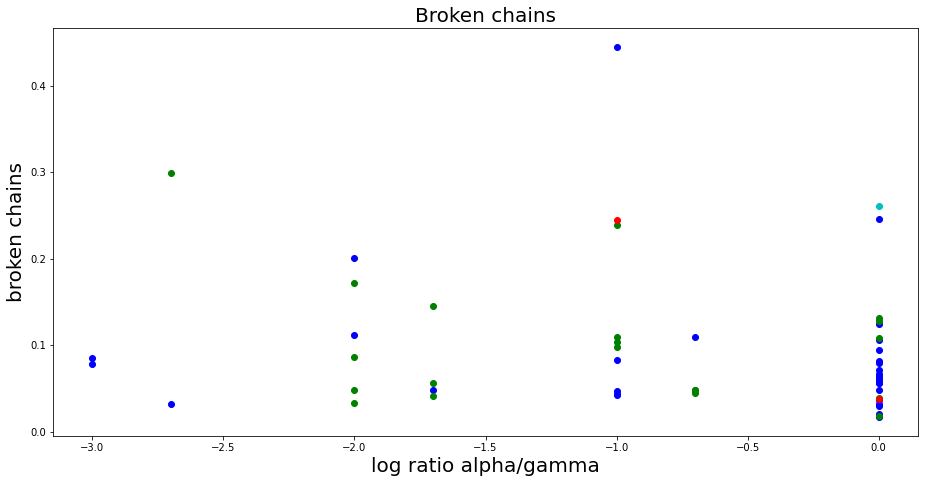

In [67]:
#BROKEN CHAINS
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()

c_code = [int(np.log10(lx)) for lx in ratio_1v_df['weight_1'].to_numpy()]

index = -1

df = ratio_1v_df    

x = df['ratio w/l']
x = [np.log10(lx) for lx in x.to_numpy()]
y = df['broken_chains']

for i in range(len(x)):
    ax.plot(x[i],y[i],'o', color=color[c_code[i]])

ax.set_xlabel('log ratio alpha/gamma', fontsize=20)
ax.set_ylabel('broken chains', fontsize=20) 
ax.set_ybound()
ax.set_title('Broken chains',fontsize=20)

#ax.set_xticks(np.arange(0,18))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

fig.set_size_inches(15.5, 7.5)

plt.show()

# Chain strength

### All feasible

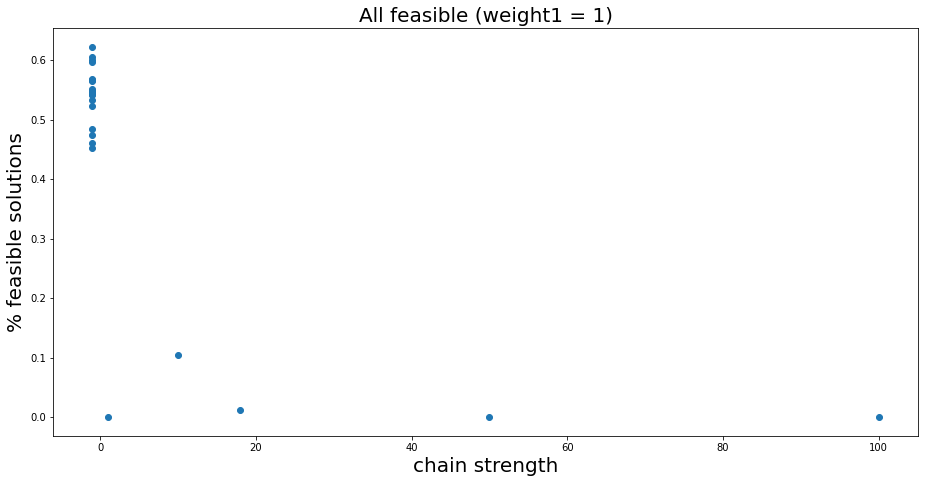

In [112]:
#FEASIBLE
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()

c_code = [int(np.log10(lx)) for lx in ratio_1v_df['weight_1'].to_numpy()]

index = -1

df = ratio_cs_1v_df    

x = df['chain_strength'][:-1]
#x = [np.log10(lx) for lx in x.to_numpy()]
y = df['ratio_feasible'][:-1]


ax.plot(x,y,'o', )

ax.set_xlabel('chain strength', fontsize=20)
ax.set_ylabel('% feasible solutions', fontsize=20) 
ax.set_ybound()
ax.set_title('All feasible (weight1 = 1)',fontsize=20)

#ax.set_xticks(np.arange(0,18))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

fig.set_size_inches(15.5, 7.5)

plt.show()

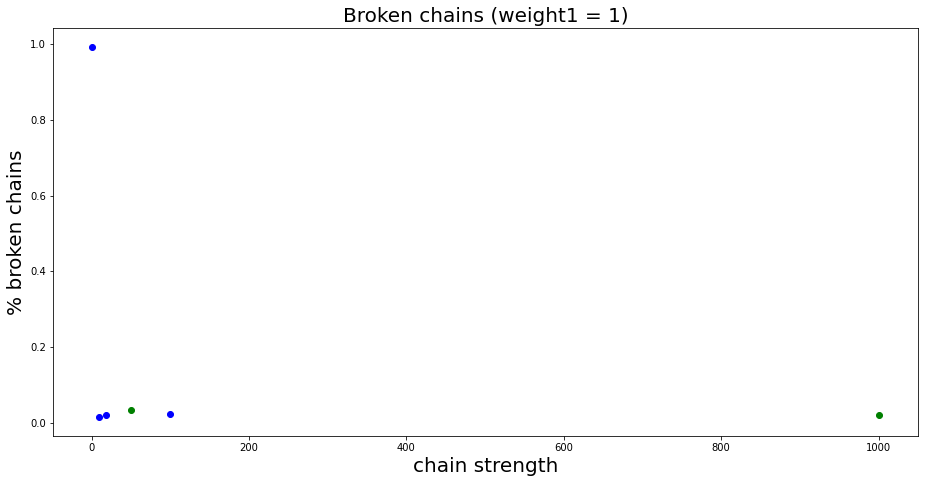

In [95]:
#BROKEN CHAINS
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()

c_code = [int(np.log10(lx)) for lx in ratio_1v_df['weight_1'].to_numpy()]

index = -1

df = ratio_cs_1v_df    

x = df['chain_strength']
#x = [np.log10(lx) for lx in x.to_numpy()]
y = df['broken_chains']

for i in range(len(x)):
    ax.plot(x[i],y[i],'o', color=color[c_code[i]])

ax.set_xlabel('chain strength', fontsize=20)
ax.set_ylabel('% broken chains', fontsize=20) 
ax.set_ybound()
ax.set_title('Broken chains (weight1 = 1)',fontsize=20)

#ax.set_xticks(np.arange(0,18))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

fig.set_size_inches(15.5, 7.5)

plt.show()

## Absolute values $\alpha$, $\gamma$

In [17]:
a = df_all[df_all['num_vacancies'] == 1]
aa = a[a['chain_strength'] == -1]
b = aa[aa['weight_2'] == 0.]
ratio_av_1v_df = b[b['ratio w/l'] == 1].sort_values(by='weight_1')
#ratio_cs_1v_df = b.sort_values(by='chain_strength')
ratio_av_1v_df

,N atoms,num_vacancies,weight_1,weight_2,lagrange,ratio w/l,num_reads,broken_chains,ratio_feasible,energy_distribution,multiplicity,chain_strength
Values,18,1,1,0,1,1.0,1000,0.049,0.549,-24.0,549,-1
Values,18,1,1,0,1,1.0,1000,0.095,0.547,-24.0,547,-1
Values,18,1,1,0,1,1.0,1000,0.030,0.565,-24.0,565,-1
Values,18,1,1,0,1,1.0,1000,0.067,0.567,-24.0,567,-1
Values,18,1,1,0,1,1.0,1000,0.125,0.523,-24.0,523,-1
Values,18,1,1,0,1,1.0,1000,0.056,0.496,-24.0,496,-1
Values,18,1,1,0,1,1.0,1000,0.072,0.551,-24.0,551,-1
Values,18,1,1,0,1,1.0,1000,0.246,0.452,-24.0,452,-1
Values,18,1,1,0,1,1.0,1000,0.060,0.568,-24.0,568,-1
Values,18,1,1,0,1,1.0,1000,0.056,0.600,-24.0,600,-1


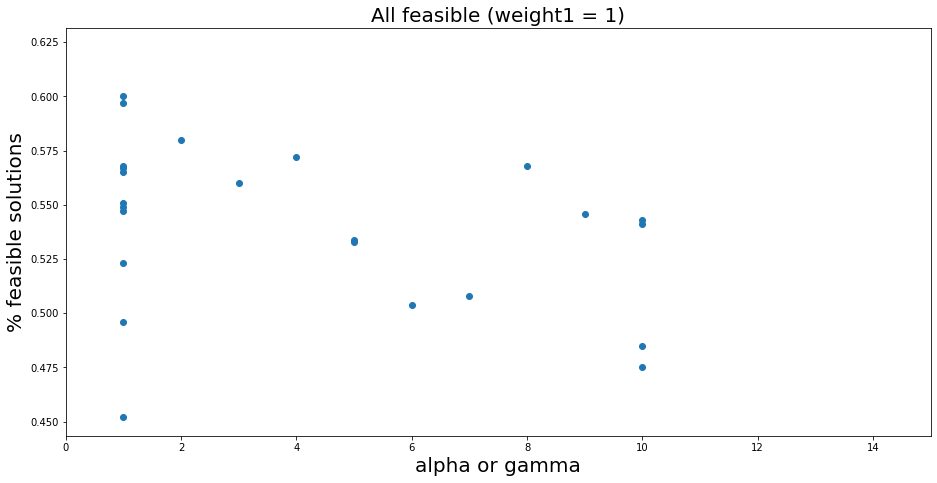

In [27]:
#FEASIBLE
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()

c_code = [int(np.log10(lx)) for lx in ratio_av_1v_df['weight_1'].to_numpy()]

index = -1

df = ratio_av_1v_df    

x = df['weight_1'][:-1]
#x = [np.log10(lx) for lx in x.to_numpy()]
y = df['ratio_feasible'][:-1]


ax.plot(x,y,'o', )

ax.set_xlabel('alpha or gamma', fontsize=20)
ax.set_ylabel('% feasible solutions', fontsize=20) 
ax.set_ybound()
ax.set_xlim([0,15])
ax.set_title('All feasible (weight1 = 1)',fontsize=20)

#ax.set_xticks(np.arange(0,18))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

fig.set_size_inches(15.5, 7.5)

plt.show()

## Symmetry of answer

[0, 2, 5, 8, 13, 14] [1.  0.5 0.5 0.5 0.5 0.5] b
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17] [0.39622642 0.50943396 0.37735849 0.79245283 0.32075472 0.52830189
 0.77358491 0.88679245 0.62264151 0.28301887 0.45283019 0.50943396
 0.58490566 0.49056604 0.9245283  1.         0.69811321 0.77358491] g
[0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 14, 15, 16, 17] [0.14285714 0.42857143 0.57142857 0.42857143 0.42857143 0.42857143
 0.14285714 1.         0.57142857 0.14285714 0.42857143 0.14285714
 0.14285714 0.42857143] r
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17] [0.50181818 0.69636364 0.45636364 0.42909091 0.63454545 0.51636364
 1.         0.41636364 0.32363636 0.49454545 0.50909091 0.54
 0.77454545 0.39272727 0.72363636 0.80363636 0.82545455 0.58363636] c


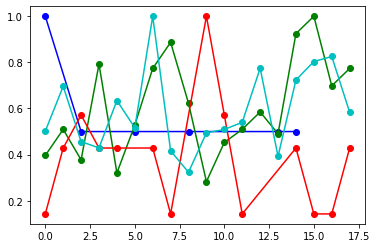

In [63]:
import os

directory = 'data/test_symmetry/'


color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()

c_code = [int(np.log10(lx)) for lx in symm_1v_df['weight_1'].to_numpy()]

index = -1

for i,filename in enumerate(os.listdir(directory)):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and f.endswith(".json") and 'bqm' in f:
        #print(f)
        df, param = load_json(f,return_param = True, return_qubo = False)
        
        x = [x for x in np.where(equivalent_energy_distribution(df,energy=-24)[0] == 0)[1]]
        y = equivalent_energy_distribution(df,energy=-24)[1]/max(equivalent_energy_distribution(df,energy=-24)[1])
        print(x,y,color[i])
        ax.plot(x,y,'-o', color=color[i])

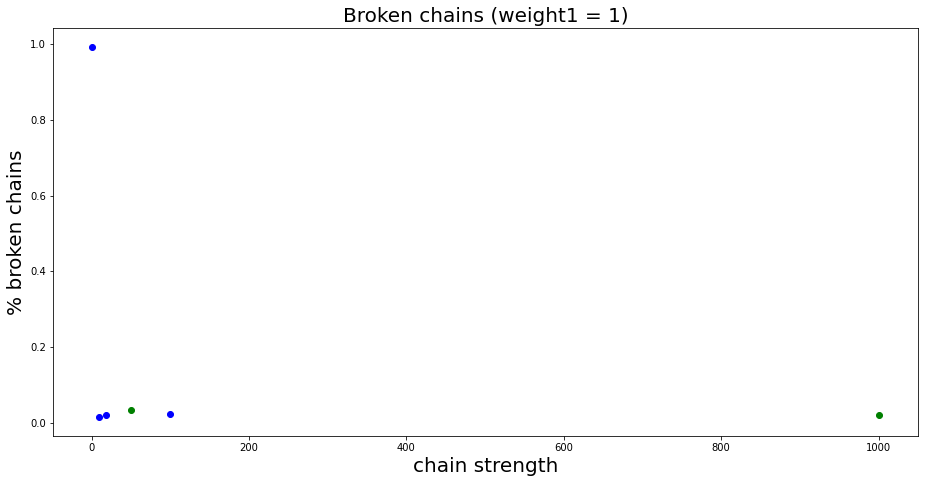

In [95]:
#BROKEN CHAINS
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()

c_code = [int(np.log10(lx)) for lx in symm_1v_df['weight_1'].to_numpy()]

index = -1

df = symm_1v_df    

x = df['chain_strength']
#x = [np.log10(lx) for lx in x.to_numpy()]
y = df['broken_chains']

for i in range(len(x)):
    ax.plot(x[i],y[i],'o', color=color[c_code[i]])

ax.set_xlabel('chain strength', fontsize=20)
ax.set_ylabel('% broken chains', fontsize=20) 
ax.set_ybound()
ax.set_title('Broken chains (weight1 = 1)',fontsize=20)

#ax.set_xticks(np.arange(0,18))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

fig.set_size_inches(15.5, 7.5)

plt.show()

In [53]:
ratio_feasible(a,num_vacancies=1,remove_broken_chains=False)

0.183

[]


TypeError: tuple indices must be integers or slices, not str

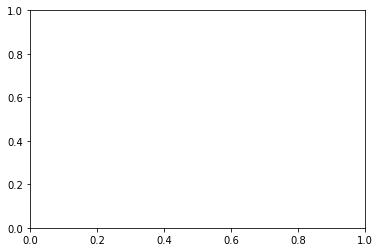

In [291]:
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()
    
index = -1
directory = './data/symmetry/'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):# and f.endswith(".json"):
        run = int(f[53:-19])
        df = load_json(f)
        index += 1
        
        config, multiplicity = equivalent_energy_distribution(df[0],energy=-24.)
        print(config)
        x = df['lagrange']
        x = [np.log10(lx) for lx in x.to_numpy()]
        y = df['ratio_feasible']

        ax.plot(x,y,'o', color=color[index])

ax.set_xlabel('Lagrange (log)', fontsize=20)
ax.set_ylabel('% feasible solutions', fontsize=20) 
ax.set_ybound()

#ax.set_xticks(np.arange(0,18))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

fig.set_size_inches(18.5, 10.5)

plt.show()

In [274]:
directory = './data/symmetry/'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):# and f.endswith(".json"):
        print(f[53:-19])

2500
500
2000
100
1500
1000


In [ ]:
config_all, energy_all, multiplicity_all = find_all_structures(dataframe, sort_config=True)

In [ ]:
np.sum(multiplicity_all)

## Chain strength

## Exact solver

In [15]:
import os

directory = 'data/test/'

dataframes = []

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and f.endswith(".json") and 'bqm' in f:
        #print(f)
        df, param = load_json(f,return_param = True, return_qubo = False)
        if np.sum(df['chain_break_fraction']==0.) > 0:
            param = param.transpose()
            n_vac = param['num_vacancies'].values[0]
            n_atoms = param['N atoms'].values[0]
            param['broken_chains'] = find_ratio_broken_chains(df)
            #param['ratio_feasible'] = ratio_feasible(df,param['num_vacancies'].values[0],remove_broken_chains=False)   
            param['ratio_feasible_nb'] = find_ratio_feasible(df,param['num_vacancies'].values[0], remove_broken_chains=True)   
            param['ratio_feasible'] = find_ratio_feasible(df,param['num_vacancies'].values[0], remove_broken_chains=False)
            param['energy_distribution_all'] = ', '.join(str(x) for x in find_energy_distribution(df)[0])
            param['multiplicity_all'] = ', '.join(str(x) for x in find_energy_distribution(df)[1])        
            param['energy_distribution'] = ', '.join(str(x) for x in find_energy_distribution(df, only_feasible=True, vacancies=param['num_vacancies'].values[0])[0])
            #param['num_broken_bonds'] = ', '.join(str(x) for x in calc_num_broken_bonds(dataframe, remove_broken_chains = True, only_feasible = True, vacancies = param['num_vacancies'].values[0]))
            param['multiplicity'] = ', '.join(str(x) for x in find_energy_distribution(df, only_feasible=True, vacancies=param['num_vacancies'].values[0])[1])
            param['ratio w/l'] = param['weight_1'] / param['lagrange']
            #print(energy_distribution(df, only_feasible=True, vacancies=n_vac))
            '''if energy_distribution(df, only_feasible=True, vacancies=n_vac)[0][0] == -(-1 - n_vac*2+n_atoms*1.5):
                param['min_found'] = True
            else:
                param['min_found'] = False'''
            if 'chain_strength' not in param:
                param['chain_strength'] = -1
            #print(param['chain_strength'])
            if param['chain_strength'].all() == None:
                param['chain_strength'] = -1
                print('YES')
            dataframes.append(param)
        else:
            print('Broken: ',f)
df_results = pd.concat(dataframes)